# Introduction

Keeping Inventory of spare in various service centre to the market demand is always a challenge as most service centres spends significant amount in spare parts inventory costs. In spite of this, availability of spare parts is been one of the problem areas. Here we are provided with bike spare parts data which consists of information reguarding the the spare part name, order date, vehicle model, etc. We are tasked with creating Predictive model for inventory forecasting so that service centre achieve Just-In-Time standards. 

In [1]:
# import required dependencies
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = (10, 6)
import seaborn as sns
pd.set_option('display.max_columns',None) 
import os
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from pandas.tseries.offsets import DateOffset
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import logging
logging.getLogger('prophet').setLevel(logging.WARNING) 

In [2]:
df = pd.read_csv('Spare_Parts_Data.csv')
df

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,30-05-17,30-05-17,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH
3,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CONSUMABLES
4,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,COOLANT OIL
...,...,...,...,...,...,...,...
28477,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,SPROCKET RUBBER
28478,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,CLUTCH CABLE
28479,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,OIL FILTER
28480,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,DISC OIL


# Basic Checks

In [3]:
print('Shape of the DataFrame:',df.shape)

Shape of the DataFrame: (28482, 7)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28482 entries, 0 to 28481
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   invoice_date           28482 non-null  object
 1   job_card_date          28482 non-null  object
 2   business_partner_name  28482 non-null  object
 3   vehicle_no             28482 non-null  object
 4   vehicle_model          28482 non-null  object
 5   current_km_reading     28482 non-null  int64 
 6   invoice_line_text      28448 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.5+ MB


In [5]:
df.describe()

,current_km_reading
count,28482.000000
mean,19348.003827
std,25246.722306
min,0.000000
25%,3988.000000
50%,12420.500000
75%,27905.000000
max,610112.000000


In [6]:
df.describe(include='O')

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,invoice_line_text
count,28482,28482,28482,28482,28482,28448
unique,555,553,1010,846,28,502
top,01-12-18,01-12-18,venkXXXXXXXXXX,KA53EVXXXX,BAJAJ PULSAR 150,ENGINE OIL
freq,179,179,424,1313,8633,3802


In [7]:
print('Datatype of Each Column: \n',df.dtypes)

Datatype of Each Column: 
 invoice_date             object
job_card_date            object
business_partner_name    object
vehicle_no               object
vehicle_model            object
current_km_reading        int64
invoice_line_text        object
dtype: object


In [8]:
print('Duplicated Values: ',df.duplicated().sum()) 

Duplicated Values:  383


In [9]:
df[df.duplicated(keep=False)]

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
24,03-06-17,31-05-17,MAYAXXXXXXXXXX,KA05JGXXXX,BAJAJ PULSAR 220,25000,DISC PAD
40,03-06-17,31-05-17,MAYAXXXXXXXXXX,KA05JGXXXX,BAJAJ PULSAR 220,25000,DISC PAD
41,05-06-17,01-06-17,srivXXXXXXXXXX,KA02EWXXXX,BAJAJ PULSAR 150,41458,BRAKE ADJUSTMENT
43,05-06-17,01-06-17,srivXXXXXXXXXX,KA02EWXXXX,BAJAJ PULSAR 150,41458,BRAKE ADJUSTMENT
577,13-06-17,13-06-17,subhXXXXXXXXXX,KA53J9XXXX,BAJAJ AVENGER STREET 220,14484,SILENCER
...,...,...,...,...,...,...,...
28318,04-01-19,04-01-19,ALOKXXXXXXXXXX,KA53EWXXXX,BAJAJ CT 100,27786,BRAKE SHOE
28343,04-01-19,04-01-19,yeshXXXXXXXXXX,KA40ECXXXX,BAJAJ PULSAR 220,11541,DISC PAD
28346,04-01-19,04-01-19,yeshXXXXXXXXXX,KA40ECXXXX,BAJAJ PULSAR 220,11541,DISC PAD
28444,05-01-19,05-01-19,ashoXXXXXXXXXX,KA53EPXXXX,BAJAJ PULSAR 150,22413,BRAKE SHOE


In [10]:
# drop duplicates
df.drop_duplicates(inplace=True)  

# Missing Values

In [11]:
df.isnull().sum()  

invoice_date              0
job_card_date             0
business_partner_name     0
vehicle_no                0
vehicle_model             0
current_km_reading        0
invoice_line_text        18
dtype: int64

In [12]:
# Pecentage of Missing Values for Each Column : 
features_with_na=[features for features in df.columns if df[features].isnull().sum()>0] 
print('The Features that have missing values are as follows: \n',features_with_na)
print('-'*125)
for feature in features_with_na:
    print('Percentage of missing values in {} Feature is {} %'.format(feature, np.round(df[feature].isnull().mean()*100, 2)))

The Features that have missing values are as follows: 
 ['invoice_line_text']
-----------------------------------------------------------------------------------------------------------------------------
Percentage of missing values in invoice_line_text Feature is 0.06 %


In [13]:
df.dropna(inplace=True)

In [14]:
df.isnull().sum().sum()

0

# Datetime Variable

In [15]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'],dayfirst=True)
df['job_card_date'] = pd.to_datetime(df['job_card_date'],dayfirst=True)

In [16]:
df.head(3)

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,2017-05-30,2017-05-30,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,2017-06-02,2017-05-31,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,2017-06-02,2017-05-31,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28081 entries, 0 to 28481
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   invoice_date           28081 non-null  datetime64[ns]
 1   job_card_date          28081 non-null  datetime64[ns]
 2   business_partner_name  28081 non-null  object        
 3   vehicle_no             28081 non-null  object        
 4   vehicle_model          28081 non-null  object        
 5   current_km_reading     28081 non-null  int64         
 6   invoice_line_text      28081 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 1.7+ MB


In [18]:
print(df.invoice_date.min())
print(df.invoice_date.max())

2017-05-30 00:00:00
2019-01-06 00:00:00


In [19]:
print(df.job_card_date.min())
print(df.job_card_date.max())

2017-05-30 00:00:00
2019-01-06 00:00:00


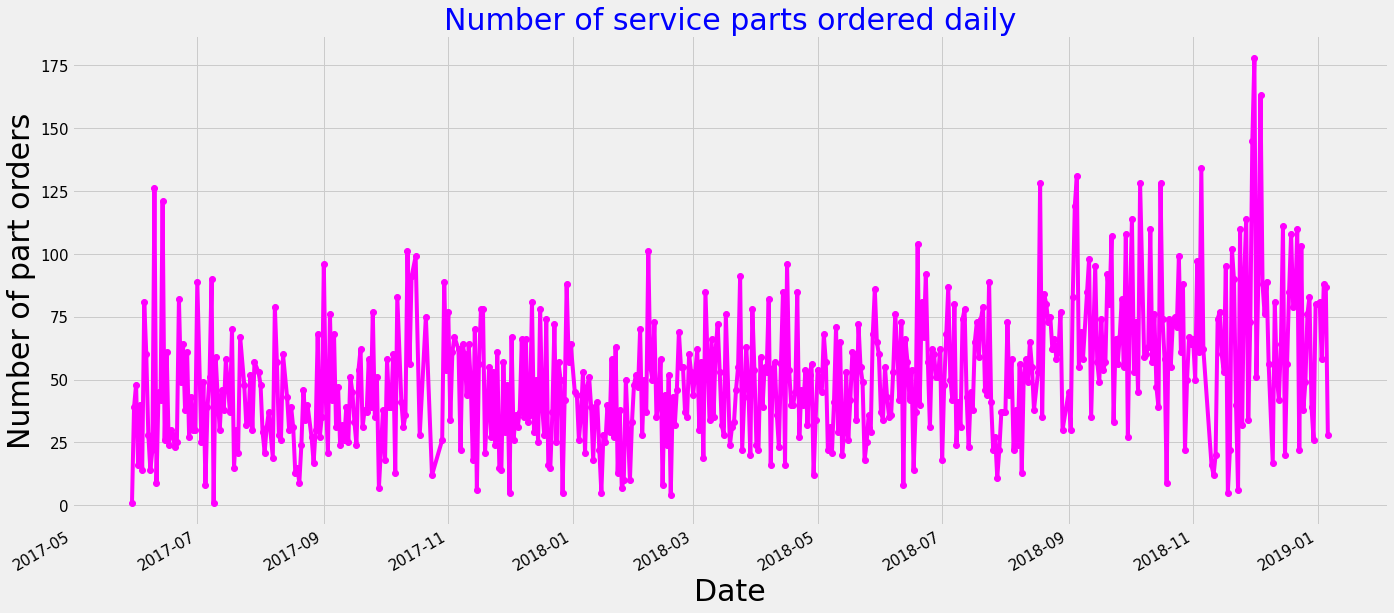

In [20]:
df.groupby('job_card_date')['job_card_date'].count().plot(figsize=(21,10),color='magenta',marker='o')
plt.title("Number of service parts ordered daily",fontsize=30,color='blue')
plt.ylabel("Number of part orders",fontsize=30)
plt.xlabel("Date",fontsize=30);

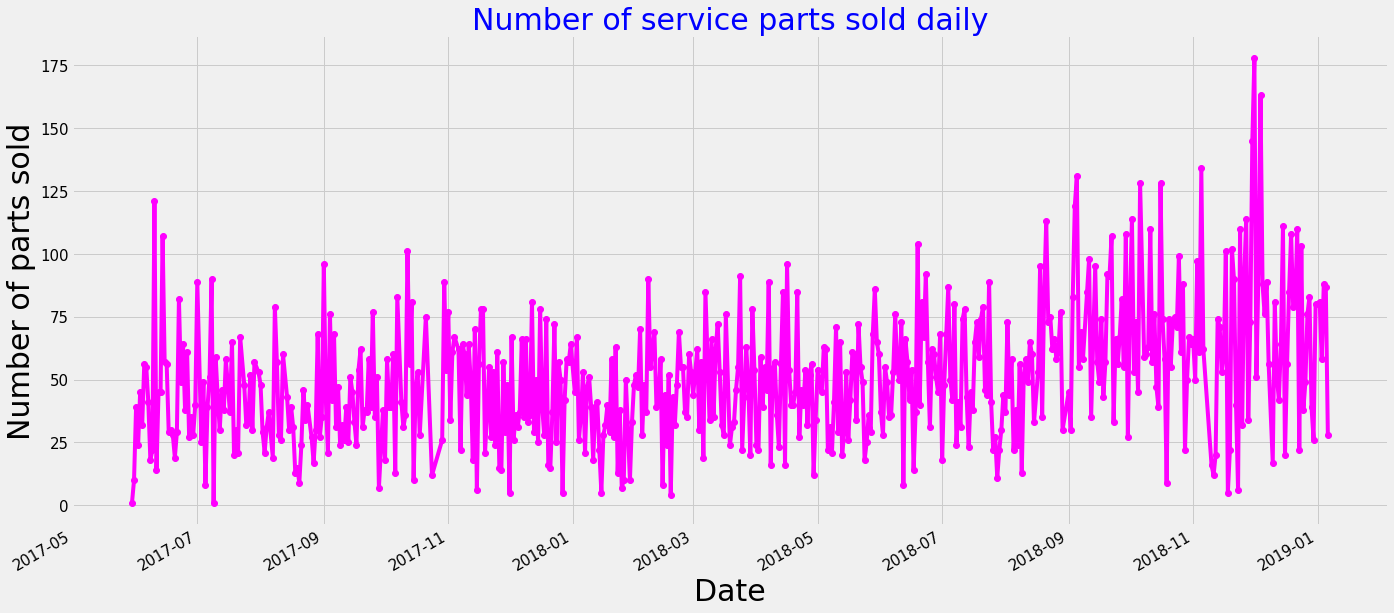

In [21]:
df.groupby('invoice_date')['invoice_date'].count().plot(figsize=(21,10),color='magenta',marker='o')
plt.title("Number of service parts sold daily",fontsize=30,color='blue')
plt.ylabel("Number of parts sold",fontsize=30)
plt.xlabel("Date",fontsize=30);

> - So there is close to 20 months of data present in this dataset starting from 30/05/2017 to 06/01/2019.
> - Some parts are sold on the same day as order date and some parts sold on a later date.

# Categorical Features

In [22]:
cat_fe = [feature for feature in df.columns if df[feature].dtype == 'O'] 
cat_fe

['business_partner_name', 'vehicle_no', 'vehicle_model', 'invoice_line_text']

# Number of Unique Categories in each Feature

In [23]:
for feature in cat_fe:
    print('The no. of unique categories in {} feature is : {}'.format(feature,df[feature].nunique()))

The no. of unique categories in business_partner_name feature is : 1010
The no. of unique categories in vehicle_no feature is : 846
The no. of unique categories in vehicle_model feature is : 28
The no. of unique categories in invoice_line_text feature is : 502


# Finding the Trends

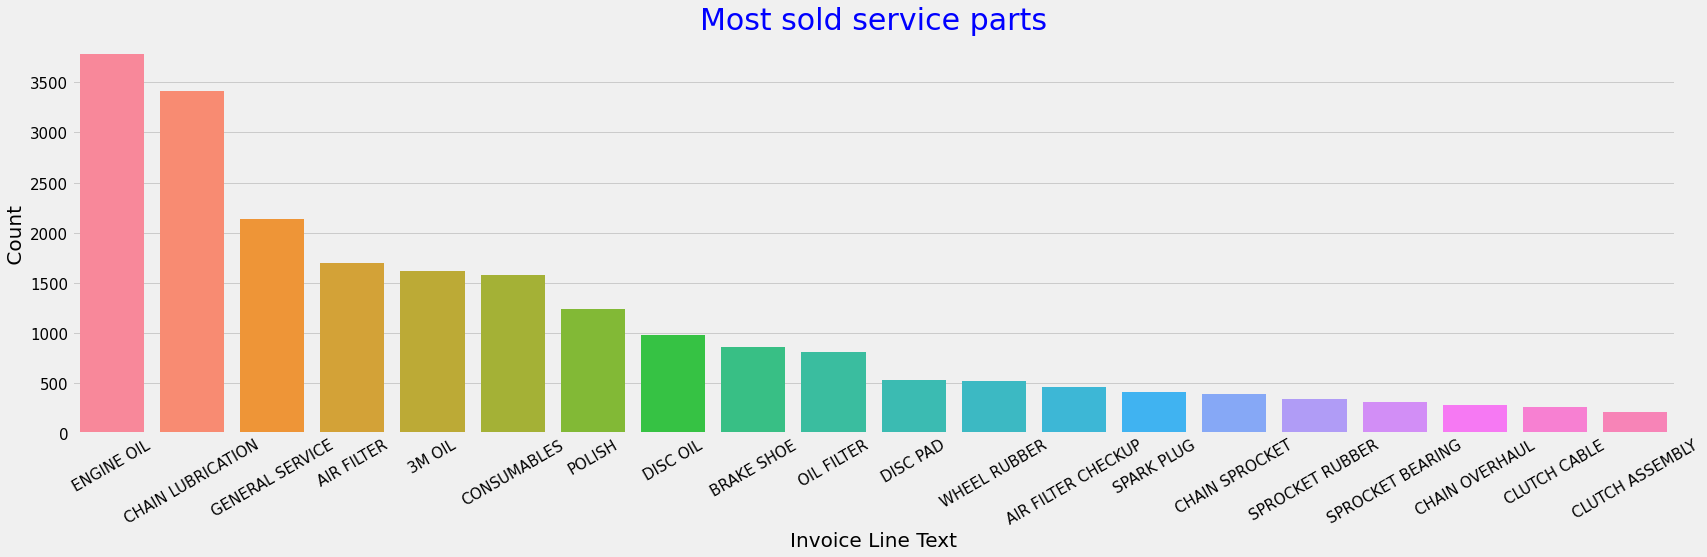

In [24]:
plt.figure(figsize=(24,8))
sns.countplot(df['invoice_line_text'],order=df['invoice_line_text'].value_counts().index[:20],saturation=10) 
plt.xticks(rotation=30)
plt.xlabel("Invoice Line Text",fontsize=20)
plt.ylabel(" Count ",fontsize=20)
plt.title("Most sold service parts",fontsize=30,color='blue')
plt.tight_layout();

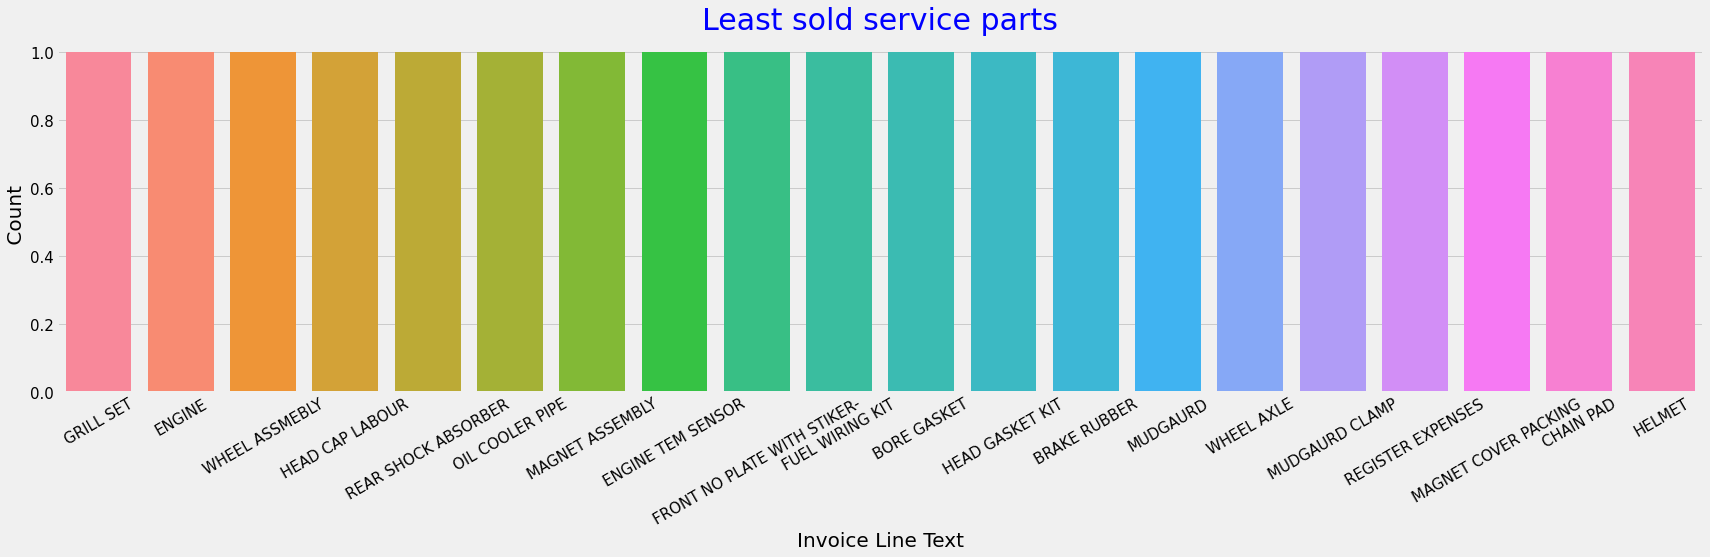

In [25]:
plt.figure(figsize=(24,8))
sns.countplot(df['invoice_line_text'],order=df['invoice_line_text'].value_counts().index[-20:],saturation=10)
plt.xticks(rotation=30)
plt.xlabel("Invoice Line Text",fontsize=20)
plt.ylabel(" Count ",fontsize=20)
plt.title("Least sold service parts",fontsize=30,color='blue')
plt.tight_layout();

> - Seems like not all parts are spare parts in invoice_line_text column and they need to be pre-processed later on.
> - As you can observe from least sold service parts, there is not enough quantity for certain individual parts and hence cannot be forecasted. 

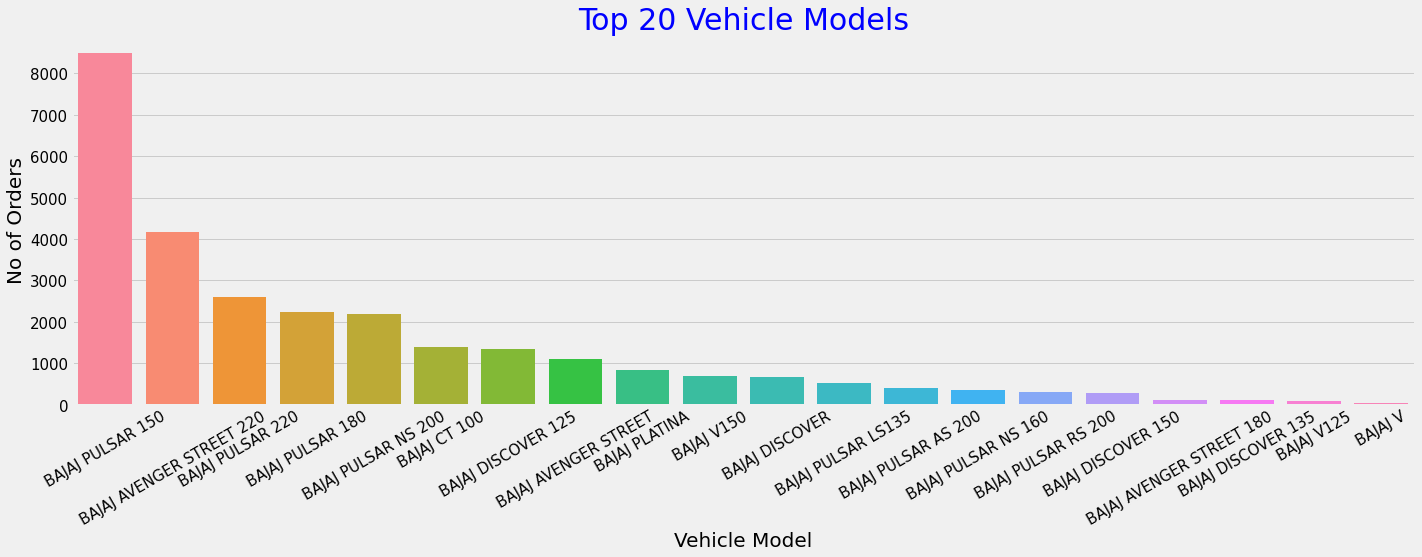

In [26]:
plt.figure(figsize=(20,8))
sns.countplot(df['vehicle_model'],order=df['vehicle_model'].value_counts().iloc[:20].index,saturation=10)
plt.xlabel("Vehicle Model",fontsize=20)
plt.ylabel("No of Orders",fontsize=20)
plt.xticks(rotation=30)
plt.title("Top 20 Vehicle Models",fontsize=30,color='blue')
plt.tight_layout();

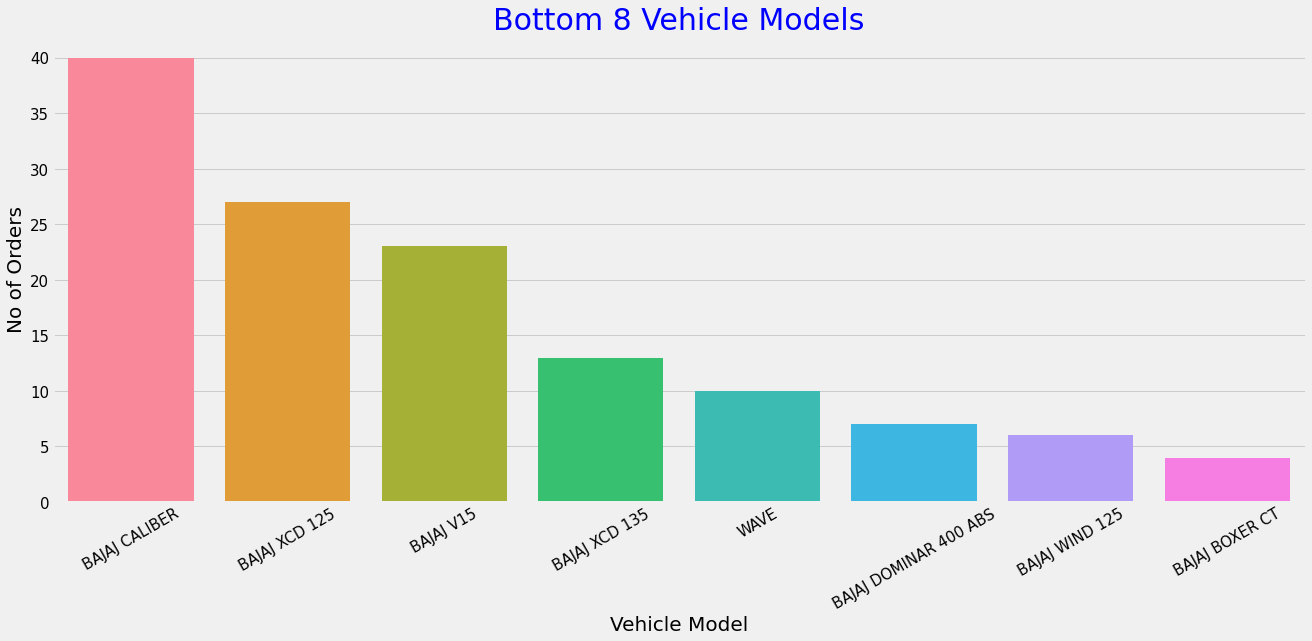

In [27]:
plt.figure(figsize=(20,8))
sns.countplot(df['vehicle_model'],order=df['vehicle_model'].value_counts().iloc[-8:].index,saturation=10)
plt.xlabel("Vehicle Model",fontsize=20)
plt.ylabel("No of Orders",fontsize=20)
plt.xticks(rotation=30)
plt.title("Bottom 8 Vehicle Models",fontsize=30,color='blue');

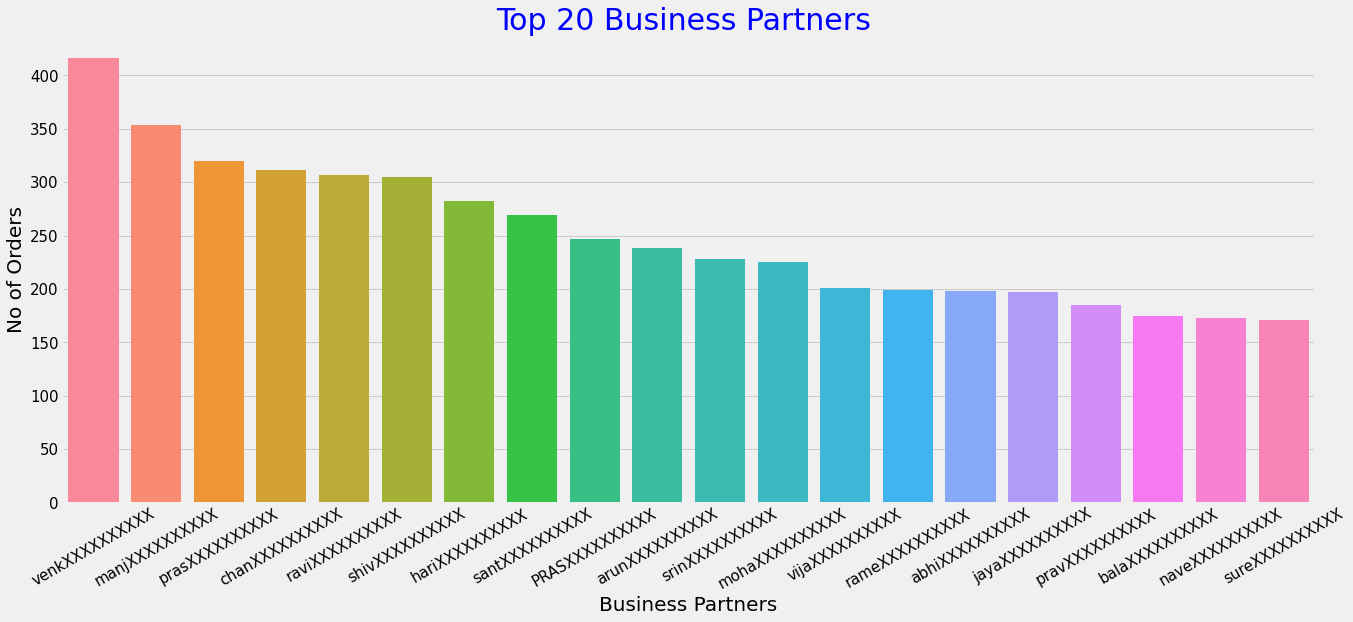

In [28]:
plt.figure(figsize=(20,8))
sns.countplot(df['business_partner_name'],order=df['business_partner_name'].value_counts().iloc[:20].index,saturation=10)
plt.xlabel("Business Partners",fontsize=20)
plt.ylabel("No of Orders",fontsize=20)
plt.xticks(rotation=30)
plt.title("Top 20 Business Partners ",fontsize=30,color='blue');

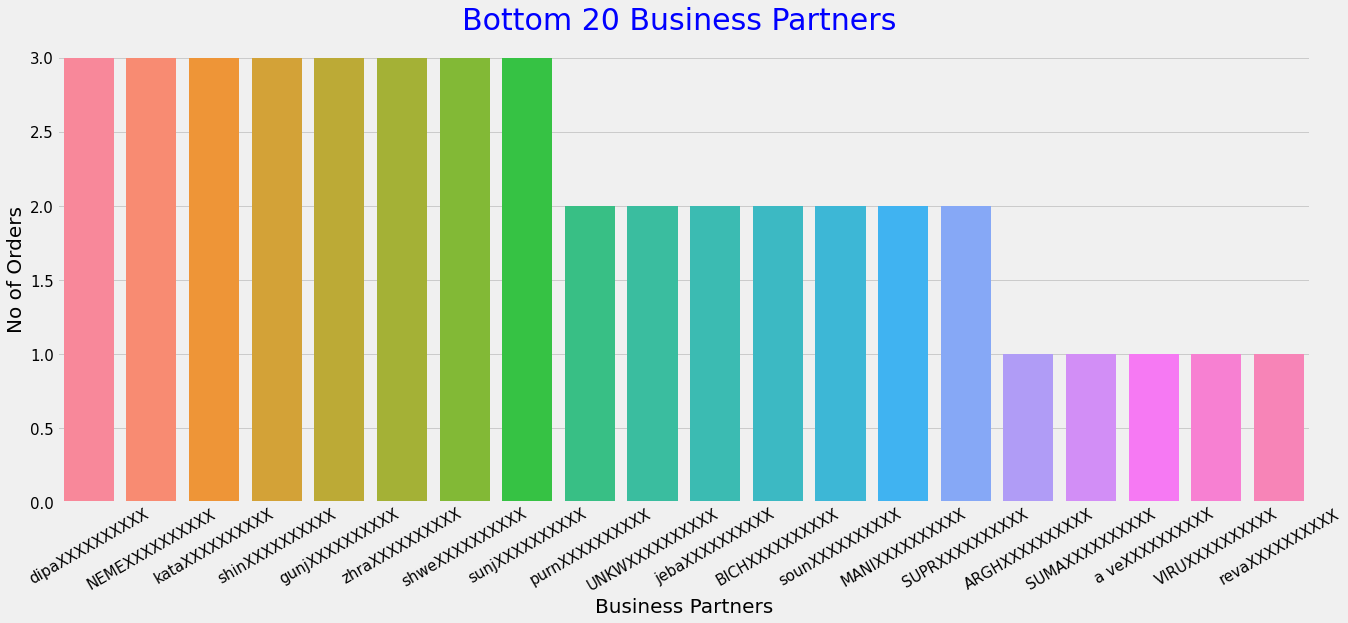

In [29]:
plt.figure(figsize=(20,8))
sns.countplot(df['business_partner_name'],order=df['business_partner_name'].value_counts().iloc[-20:].index,saturation=10)
plt.xlabel("Business Partners",fontsize=20)
plt.ylabel('No of Orders',fontsize=20)
plt.xticks(rotation=30)
plt.title("Bottom 20 Business Partners ",fontsize=30,color='blue');

# Numerical Features

In [30]:
num_fe = ['current_km_reading']

In [31]:
df.current_km_reading.describe()

count     28081.000000
mean      19335.123037
std       25301.781847
min           0.000000
25%        3959.000000
50%       12347.000000
75%       27906.000000
max      610112.000000
Name: current_km_reading, dtype: float64

<AxesSubplot:xlabel='current_km_reading', ylabel='Count'>

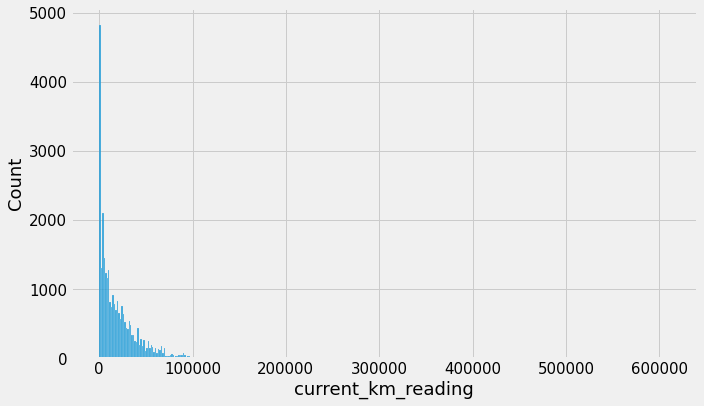

In [32]:
sns.histplot(df.current_km_reading)

# Target Variable

In [33]:
pd.set_option('display.max_rows',None) 

In [34]:
df['invoice_line_text'].value_counts()

ENGINE OIL                                        3780
CHAIN LUBRICATION                                 3417
GENERAL SERVICE                                   2132
AIR FILTER                                        1698
3M OIL                                            1615
CONSUMABLES                                       1582
POLISH                                            1236
DISC OIL                                           985
BRAKE SHOE                                         861
OIL FILTER                                         814
DISC PAD                                           530
WHEEL RUBBER                                       518
AIR FILTER CHECKUP                                 467
SPARK PLUG                                         414
CHAIN SPROCKET                                     394
SPROCKET RUBBER                                    344
SPROCKET BEARING                                   311
CHAIN OVERHAUL                                     283
CLUTCH CAB

In [35]:
pd.reset_option('display.max_rows')

> - Target contains names of different spare parts as well as other miscellaneous things such as service charge, labour, cleaning, etc.
> - We are interested in parts/items/consumables only. Only parts/items/consumbables need to procured from manufacturer, so requirement forecasting has to be done only for these parts.
> - Next we do some pre-processing where we keep things that are only required and remove the rest of them.

In [36]:
labels_to_delete = ['CHARGE', 'INSURANCE', 'PAYMENT', 'REGISTER', 'ADJUSTMENT', 'NUMBER PLATE','PACKING',
                    'REMOVAL', 'THREADING', 'CLEANING', 'FEES', 'REBORE', 'PUNCHER', 'EX SHOW ROOM', 'CRANK RESET',
                    'DENT', 'RC CARD', 'TAX', 'ENGINE WORK','SERVICE', 'CHECK', 'LABOUR', 'POLISH','TOP UP','TOPUP',
                    'LOGO','HAND GLOUSE', 'NO PLATE', 'WELDING','WIELDING','WASHING','OVERHUAL','OVERHAUL','STICKER',
                    'ENGINE RE CONDITION','STAY'] 

In [37]:
df1=df.copy()

for index, text in df1['invoice_line_text'].iteritems():
    if text == 'SERVICE AND ONE WAY CLUTCH BUSH KIT':
        print('Changed the text from "SERVICE AND ONE WAY CLUTCH BUSH KIT" to "ONE WAY CLUTCH BUSH KIT"')
        df1.loc[index, 'invoice_line_text'] = 'ONE WAY CLUTCH BUSH KIT'
    
    if text == 'tyre':
        print('Changed the text from "tyre" to "TYRE"')
        df1.loc[index, 'invoice_line_text'] = 'TYRE'        

    if text == 'TYRE REPLACEMENT':
        print('Changed the text from "TYRE REPLACEMENT" to "TYRE"')
        df1.loc[index, 'invoice_line_text'] = 'TYRE'

    if text == 'VISIOR WITH LABOUR':
        print('Changed the text from "VISIOR WITH LABOUR" to "VISIOR"')
        df1.loc[index, 'invoice_line_text'] = 'VISIOR'
        
    if text.strip() == 'PETROL':
        print('Deleting line that has PETROL only')
        df1.drop(index=index, inplace=True)
        
    if text == 'clutch cable':
        print('Changed the text from "clutch cable" to "CLUTCH CABLE"')
        df1.loc[index, 'invoice_line_text'] = 'CLUTCH CABLE'
        
    if text == 'Clutch cable':
        print('Changed the text from "Clutch cable" to "CLUTCH CABLE"')
        df1.loc[index, 'invoice_line_text'] = 'CLUTCH CABLE'

    if text == 'Clutch CABLE':
        print('Changed the text from "Clutch CABLE" to "CLUTCH CABLE"')   
        df1.loc[index, 'invoice_line_text'] = 'CLUTCH CABLE'
        
    if text == 'CLUTCH REPALCEMENT':
        print('Changed the text from "CLUTCH REPALCEMENT" to "CLUTCH"')
        df1.loc[index, 'invoice_line_text'] = 'CLUTCH'
        
    if text == 'DOOM REPLACEMENT':
        print('Changed the text from "DOOM REPLACEMENT" to "DOOM"')
        df1.loc[index, 'invoice_line_text'] = 'DOOM'

    if text == 'handle weight':
        print('Changed the text from "handle weight" to "HANDLE WEIGHT"')
        df1.loc[index, 'invoice_line_text'] = 'HANDLE WEIGHT'
        
    if text == 'INTAKE':
        print('Changed the text from "INTAKE" to "AIR INTAKE"')
        df1.loc[index, 'invoice_line_text'] = 'AIR INTAKE'
        
    if text == 'SPPEDOMETER CABLE':
        print('Changed the text from "SPPEDOMETER CABLE" to "SPPEDOMETER CABLE"')
        df1.loc[index, 'invoice_line_text'] = 'SPPEDOMETER CABLE'
        
    if text == 'SELF REALY':
        print('Changed the text from "SELF REALY" to "SELF RELAY"')
        df1.loc[index, 'invoice_line_text'] = 'SELF RELAY'
        
    if text == 'CHAIN LUBRICATION':
        print('Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"')
        df1.loc[index, 'invoice_line_text'] = 'CHAIN LUBRICANT'
        
    for del_label in labels_to_delete:
        if text.upper().find(del_label) != -1:
            print('Deleting line with text : ', text)
            df1.drop(index=index, inplace=True,errors='ignore')


Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  PACKING KIT
Deleting line with text :  BRAKE ADJUSTMENT
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  AIR FILTER CHECKUP
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  TANK CLEANING
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Changed the text from "Clutc

Deleting line with text :  GENERAL SERVICE
Deleting line with text :  PACKING KIT
Deleting line with text :  CRANK RESET
Deleting line with text :  WIRING CHECKUP
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  POLISH
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  WASHING
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to 

Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  LABOUR
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  POLISH
Changed the text from "CHAIN LUB

Changed the text from "clutch cable" to "CLUTCH CABLE"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  GENERAL SERVICE
Changed the text from "clutch cable" to "CLUTCH CABLE"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  STICKER
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting 

Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "clutch cable" to "CLUTCH CABLE"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Changed the text from "clutch cable" to "CLUTCH CABLE"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "clutch cable" to "CLUTCH CABLE"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBR

Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "clutch cable" to "CLUTCH CABLE"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with te

Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "TYRE REPLACEMENT" to "TYRE"
Deleting line with text :  AIR FILTER CHECKUP
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "tyre" to "TYRE"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Delet

Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "clutch cable" to "CLUTCH CABLE"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Chang

Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  LABOUR
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  LABOUR
Deleting line with text :  WASHING
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHEC

Deleting line with text :  POLISH
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  AIR FILTER CHECKUP
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICAT

Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CHAIN OVERHAUL
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  NUMBER PLATE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CHAIN OVERHAUL
Changed the text from "CHAIN LUBRICATION" to "

Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting

Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "SPPEDOMETER CABLE" to "SPPEDOMETER CABLE"
Deleting line with text :  AIR FILTER CHECKUP
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUB

Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
D

Deleting line with text :  WIRING CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  BATTERY CHARGE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  AIR FILTER CHECKUP
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  WASHING
Deleting line with text :  CHAIN OVERHAUL
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUB

Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  PACKING KIT
Dele

Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  LABOUR
Deleting line with text :  WASHING
Deleting line with text :  EX SHOW ROOM
Deleting line with text :  REGISTER EXPENSES
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "TYRE REPLACEMENT" to "TYRE"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  POLISH
Deleting 

Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the

Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  PACKING
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  LABOUR
Deleting line with text :  COIL CHECK
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  LABOUR
Deleting line with text :  COIL CHECK
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to 

Deleting line with text :  POLISH
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  WASHING
Deleting line with text :  LABOUR
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  LABOUR
Deleting line with text :  PACKING KIT
Deleting line with text :  CASE WELDING
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUB

Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  PACKING KIT
Deleting line with text :  CRANK RESET
Deleting line with text :  ENGINE LABOUR
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  RC CARD
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the t

Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  ENGINE LABOUR
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  SERVICE
Deleting line with text :  PACKING KIT
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  AIR FILTER CHECKUP
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT

Deleting line with text :  AIR FILTER CHECKUP
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  WIRING CHECK WITH LABOR
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting

Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CHAIN OVERHAUL
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  POLISH
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Changed the text from "CHAIN LUBRICATIO

Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  FORK OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  ENGINE LABOUR
Deleting line with text :  CRANK RESET
Deleting line with text :  PACKING KIT
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT

Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  ENGINE LABOUR
Deleting line with text :  PACKING KIT
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  AIR FILTER CHECKUP
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
D

Deleting line with text :  LABOUR
Deleting line with text :  COIL CHECK
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  LABOUR
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line w

Deleting line with text :  POLISH
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  PACKING KIT
Deleting line with text :  CRANK RESET
Deleting line with text :  ENGINE LABOUR
Deleting line with text :  COIL CHECK
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  GENERAL SERVICE
Changed the 

Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  WIND SHIELD LOGO
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  FORK OVERHUAL
Deleting line with text :  DISC OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  FORK OVERHUAL
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text : 

Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  GENERAL SERVICE
Deleting line with

Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  STOPPER WELDING
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CLUTCH OVERHUAL
Changed the text from "SELF REALY" to "SELF RELAY"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN L

Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CLUTCH OVERHUAL
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  FORK OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  PACKING KIT
Deleting line with text :  ENGINE LABOUR
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  CRANK RESET
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  GENERAL SERVICE
Changed the text 

Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CLUTCH OVERHUAL
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  FORK OVERHUAL
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  DISC OVERHUAL
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting lin

Deleting line with text :  CHAIN OVERHAUL
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  FORK OVERHUAL
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  LABOUR
Deleting line with text :  COIL CHECK
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  FORK OVERHUAL
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line

Deleting line with text :  COIL CHECK
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  LABOUR
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "TYRE REPLACEMENT" to "TYRE"
Changed the text from "CHAIN LUBRICATION" to "CHAIN 

Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CLUTCH OVERHUAL
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CLUTCH OVERHUAL
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  DISC OVERHUAL
Deleting line with text :  WIRING CHECKUP
Deleting line with text :  DISC OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CHAIN OVERHAUL
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line w

Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  POLISH
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  FORK OVERHUAL
Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  CHAIN OVERHAUL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICA

In [38]:
pd.set_option('display.max_rows',None) 
df1['invoice_line_text'].value_counts()

ENGINE OIL                                        3780
CHAIN LUBRICANT                                   3417
AIR FILTER                                        1698
3M OIL                                            1615
CONSUMABLES                                       1582
DISC OIL                                           985
BRAKE SHOE                                         861
OIL FILTER                                         814
DISC PAD                                           530
WHEEL RUBBER                                       518
SPARK PLUG                                         414
CHAIN SPROCKET                                     394
SPROCKET RUBBER                                    344
CLUTCH CABLE                                       340
SPROCKET BEARING                                   311
CLUTCH ASSEMBLY                                    209
CLUTCH COVER GASKET                                187
TANK COVER                                         133
SEAT COVER

In [39]:
pd.reset_option('display.max_rows')

In [40]:
df1.shape

(22979, 7)

In [41]:
df1.isnull().sum().sum()

0

## Further EDA of Target Variable

> - We will group the target variable by 'job_card_date' .
> - If you would take it by actual invoice date, this would mean you will plan not according to your initial demand, 
but according to how you managed to fulfill this demand.
> - When doing the planning, it is important to rely on the initial demand.

In [42]:
df2 = df1[['job_card_date','invoice_line_text']]
df2

,job_card_date,invoice_line_text
0,2017-05-30,ENGINE OIL
1,2017-05-31,ENGINE OIL
3,2017-05-31,CONSUMABLES
4,2017-05-31,COOLANT OIL
5,2017-05-31,CHAIN LUBRICANT
...,...,...
28477,2019-01-06,SPROCKET RUBBER
28478,2019-01-06,CLUTCH CABLE
28479,2019-01-06,OIL FILTER
28480,2019-01-06,DISC OIL


In [43]:
df2.invoice_line_text.value_counts().count()

401

In [44]:
df2.invoice_line_text.value_counts()[0:10].sum()

15800

In [45]:
(df2.invoice_line_text.value_counts()[0:10].sum() * 100 ) / df2.invoice_line_text.value_counts().sum()

68.75843161147134

In [46]:
# first 20 out of 401 make up 18.3K record of total of 23K record
df2.invoice_line_text.value_counts()[0:20].sum() 

18359

In [47]:
(df2.invoice_line_text.value_counts()[0:20].sum() * 100 ) / df2.invoice_line_text.value_counts().sum() 

79.89468645284825

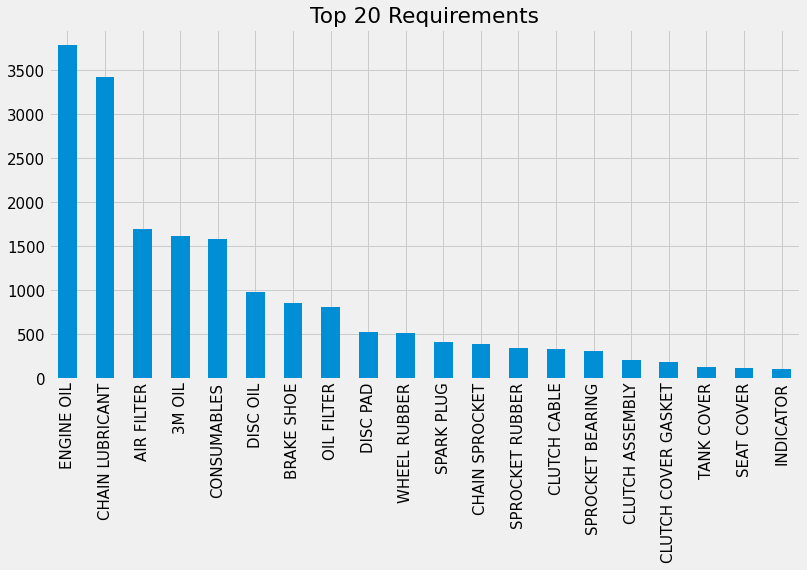

In [48]:
# Top 20 Requirements
df2.invoice_line_text.value_counts().nlargest(20).plot(kind='bar', title="Top 20 Requirements", figsize=(12,6));

In [49]:
df3 = df2.invoice_line_text.value_counts().to_frame()
df3

,invoice_line_text
ENGINE OIL,3780
CHAIN LUBRICANT,3417
AIR FILTER,1698
3M OIL,1615
CONSUMABLES,1582
...,...
WHEEL AXLE,1
MUDGAURD CLAMP,1
CHAIN PAD,1
DISK PLATE,1


In [50]:
df3 = df3.rename(columns={'invoice_line_text':'Count'})
df3

,Count
ENGINE OIL,3780
CHAIN LUBRICANT,3417
AIR FILTER,1698
3M OIL,1615
CONSUMABLES,1582
...,...
WHEEL AXLE,1
MUDGAURD CLAMP,1
CHAIN PAD,1
DISK PLATE,1


In [51]:
df3['item_total']=np.cumsum(df3['Count'])
df3['item_percentage']=(df3['Count']*100)/df3['Count'].sum()
df3['cum_perc'] = np.cumsum(df3['item_percentage'])

In [52]:
df3

,Count,item_total,item_percentage,cum_perc
ENGINE OIL,3780,3780,16.449802,16.449802
CHAIN LUBRICANT,3417,7197,14.870099,31.319901
AIR FILTER,1698,8895,7.389355,38.709256
3M OIL,1615,10510,7.028156,45.737412
CONSUMABLES,1582,12092,6.884547,52.621959
...,...,...,...,...
WHEEL AXLE,1,22975,0.004352,99.982593
MUDGAURD CLAMP,1,22976,0.004352,99.986945
CHAIN PAD,1,22977,0.004352,99.991296
DISK PLATE,1,22978,0.004352,99.995648


In [53]:
df3.loc[df3.cum_perc<80]

,Count,item_total,item_percentage,cum_perc
ENGINE OIL,3780,3780,16.449802,16.449802
CHAIN LUBRICANT,3417,7197,14.870099,31.319901
AIR FILTER,1698,8895,7.389355,38.709256
3M OIL,1615,10510,7.028156,45.737412
CONSUMABLES,1582,12092,6.884547,52.621959
DISC OIL,985,13077,4.286522,56.908482
BRAKE SHOE,861,13938,3.746899,60.655381
OIL FILTER,814,14752,3.542365,64.197746
DISC PAD,530,15282,2.306454,66.504199
WHEEL RUBBER,518,15800,2.254232,68.758432


In [54]:
df3.loc[df3.cum_perc<80].shape

(20, 4)

In [55]:
df3.loc[df3.Count<50]

,Count,item_total,item_percentage,cum_perc
FORK BEND,47,20604,0.204535,89.664476
ENGINE GUARD,46,20650,0.200183,89.864659
SPEEDOMETER CABLE,46,20696,0.200183,90.064842
HALF ACCELERATOR,44,20740,0.191479,90.256321
SWITCH,44,20784,0.191479,90.447800
...,...,...,...,...
WHEEL AXLE,1,22975,0.004352,99.982593
MUDGAURD CLAMP,1,22976,0.004352,99.986945
CHAIN PAD,1,22977,0.004352,99.991296
DISK PLATE,1,22978,0.004352,99.995648


In [56]:
df3.loc[df3.Count<50].shape 

(350, 4)

> - From data, there are 350 items ordered less than 50 times over a period of 20 months. That is like aprroximately 2 parts per month for which order frequency is not sufficient for good forecasting  
> - So not all parts can be forecasted.
> - Top 20 parts makes up 80% of the total orders.
> - Our forecasting model should atleast forecast 80% of the orders so that it is significantly useful to customer.

## Analysis of target variable with respect to other factors

In [57]:
df1[['vehicle_model','invoice_line_text']].groupby('vehicle_model').describe()

invoice_line_text                              
                                     count unique              top  freq
vehicle_model                                                           
BAJAJ AVENGER STREET                   872     86       ENGINE OIL   171
BAJAJ AVENGER STREET 180                99      9      CONSUMABLES    23
BAJAJ AVENGER STREET 220              3358    177       ENGINE OIL   588
BAJAJ BOXER CT                           1      1       SPARK PLUG     1
BAJAJ CALIBER                           30     19       ENGINE OIL     5
BAJAJ CT 100                          1172     63       ENGINE OIL   241
BAJAJ DISCOVER                         534     97       ENGINE OIL    82
BAJAJ DISCOVER 125                    1110    117       ENGINE OIL   168
BAJAJ DISCOVER 135                      94     39       ENGINE OIL    13
BAJAJ DISCOVER 150                     223     57       ENGINE OIL    36
BAJAJ DOMINAR 400 ABS                    6      6       OIL FILTER     1
BAJAJ PLATINA                          705     55       ENGINE OIL   127
BAJAJ PULSAR 150                      6969    249       ENGINE OIL  1059
BAJAJ PULSAR 180                      1839    143       ENGINE OIL   302
BAJAJ PULSAR 220                      2114    175       ENGINE OIL   335
BAJAJ PULSAR AS 200                    324     72       ENGINE OIL    46
BAJAJ PULSAR LS135                     417     70       ENGINE OIL    53
BAJAJ PULSAR NS 160                    314     35  CHAIN LUBRICANT    58
BAJAJ PULSAR NS 200                   1807    115       ENGINE OIL   296
BAJAJ PULSAR RS 200                    249     38       ENGINE OIL    44
BAJAJ V                                 41     16       ENGINE OIL     9
BAJAJ V125                              78     15  CHAIN LUBRICANT    15
BAJAJ V15                               17      9       ENGINE OIL     3
BAJAJ V150                             563     44       ENGINE OIL    97
BAJAJ WIND 125                           4      4  CHAIN LUBRICANT     1
BAJAJ XCD 125                           21     10       ENGINE OIL     5
BAJAJ XCD 135                           10      7       ENGINE OIL     2
WAVE                                     8      8       ENGINE OIL     1

In [58]:
df1.groupby(['vehicle_model','invoice_line_text']).size().nlargest(15)

vehicle_model             invoice_line_text
BAJAJ PULSAR 150          ENGINE OIL           1059
                          CHAIN LUBRICANT       962
BAJAJ AVENGER STREET 220  ENGINE OIL            588
BAJAJ PULSAR 150          AIR FILTER            546
BAJAJ AVENGER STREET 220  CHAIN LUBRICANT       537
BAJAJ PULSAR 150          3M OIL                396
                          CONSUMABLES           382
                          BRAKE SHOE            348
BAJAJ PULSAR 220          ENGINE OIL            335
BAJAJ PULSAR 150          DISC OIL              320
BAJAJ PULSAR 180          ENGINE OIL            302
BAJAJ AVENGER STREET 220  AIR FILTER            300
BAJAJ PULSAR 220          CHAIN LUBRICANT       296
BAJAJ PULSAR NS 200       ENGINE OIL            296
                          CHAIN LUBRICANT       287
dtype: int64

In [59]:
df1[['business_partner_name','vehicle_model','invoice_line_text']].groupby(['business_partner_name','vehicle_model']).describe().head(50)

invoice_line_text         \
                                                           count unique   
business_partner_name vehicle_model                                       
A J XXXXXXXXXX        BAJAJ PULSAR 180                        17      9   
A VEXXXXXXXXXX        BAJAJ PULSAR NS 200                     19     10   
A jyXXXXXXXXXX        BAJAJ PULSAR NS 200                      5      5   
A suXXXXXXXXXX        BAJAJ PULSAR RS 200                      6      6   
ABHIXXXXXXXXXX        BAJAJ AVENGER STREET 220                 4      4   
                      BAJAJ PULSAR 150                         2      2   
                      BAJAJ PULSAR 180                        29     27   
                      BAJAJ PULSAR AS 200                     14     12   
                      BAJAJ PULSAR NS 200                      6      5   
ABIRXXXXXXXXXX        BAJAJ PULSAR NS 200                      9      7   
ABISXXXXXXXXXX        BAJAJ AVENGER STREET 220                 6      6   
ADHIXXXXXXXXXX        BAJAJ PULSAR 150                        12     12   
ADITXXXXXXXXXX        BAJAJ AVENGER STREET 220                 7      6   
                      BAJAJ PULSAR 150                         5      5   
                      BAJAJ PULSAR 180                         9      9   
ADIVXXXXXXXXXX        BAJAJ PULSAR 150                        20     11   
AISHXXXXXXXXXX        BAJAJ PULSAR 150                         5      5   
AJAYXXXXXXXXXX        BAJAJ AVENGER STREET 220                 8      8   
                      BAJAJ PULSAR 150                         6      5   
AJOSXXXXXXXXXX        BAJAJ PULSAR 150                        14      8   
AKSAXXXXXXXXXX        BAJAJ PULSAR 150                         4      4   
AKSHXXXXXXXXXX        BAJAJ AVENGER STREET 220                 5      5   
ALOKXXXXXXXXXX        BAJAJ CT 100                            24     15   
AMALXXXXXXXXXX        BAJAJ PULSAR NS 200                      5      5   
AMITXXXXXXXXXX        BAJAJ DISCOVER 125                       5      5   
                      BAJAJ PULSAR 150                         5      5   
                      BAJAJ V150                              14      6   
AMOLXXXXXXXXXX        BAJAJ AVENGER STREET 220                36     16   
ANANXXXXXXXXXX        BAJAJ PULSAR 150                        11      7   
                      BAJAJ PULSAR NS 200                     42     22   
ANILXXXXXXXXXX        BAJAJ PULSAR 150                        73     42   
                      BAJAJ PULSAR 180                        16      8   
ANIMXXXXXXXXXX        BAJAJ PULSAR LS135                       4      4   
ANISXXXXXXXXXX        BAJAJ AVENGER STREET 220                 5      5   
                      BAJAJ PULSAR 150                         4      4   
ANJAXXXXXXXXXX        BAJAJ PULSAR 220                        19     12   
ANKIXXXXXXXXXX        BAJAJ PULSAR 180                         3      3   
ANKUXXXXXXXXXX        BAJAJ AVENGER STREET                    12      9   
ANMOXXXXXXXXXX        BAJAJ PULSAR 180                         4      4   
ANOOXXXXXXXXXX        BAJAJ AVENGER STREET 220                18     13   
ANSUXXXXXXXXXX        BAJAJ AVENGER STREET 220                11      8   
ARBIXXXXXXXXXX        BAJAJ DISCOVER                          16     15   
ARPIXXXXXXXXXX        BAJAJ DISCOVER                           5      5   
ARUNXXXXXXXXXX        BAJAJ CT 100                             5      5   
                      BAJAJ PULSAR NS 200                     13      8   
                      BAJAJ PULSAR RS 200                      4      4   
ARVIXXXXXXXXXX        BAJAJ V150                               7      7   
ASHOXXXXXXXXXX        BAJAJ AVENGER STREET 220                11      7   
                      BAJAJ PULSAR AS 200                      9      9   
ASHUXXXXXXXXXX        BAJAJ DISCOVER 150                      15     12   

                                                                      


In [60]:
df1.groupby(['business_partner_name','vehicle_model','invoice_line_text']).size().nlargest(15)

business_partner_name  vehicle_model             invoice_line_text
shivXXXXXXXXXX         BAJAJ PULSAR 150          ENGINE OIL           19
venkXXXXXXXXXX         BAJAJ PULSAR 150          ENGINE OIL           18
shivXXXXXXXXXX         BAJAJ PULSAR 150          CHAIN LUBRICANT      17
venkXXXXXXXXXX         BAJAJ PULSAR 150          CHAIN LUBRICANT      16
prasXXXXXXXXXX         BAJAJ PULSAR 150          ENGINE OIL           15
abhiXXXXXXXXXX         BAJAJ AVENGER STREET 220  ENGINE OIL           14
hariXXXXXXXXXX         BAJAJ PULSAR 150          ENGINE OIL           14
sathXXXXXXXXXX         BAJAJ PULSAR 150          ENGINE OIL           14
srinXXXXXXXXXX         BAJAJ PULSAR 150          ENGINE OIL           14
abhiXXXXXXXXXX         BAJAJ AVENGER STREET 220  CHAIN LUBRICANT      13
hariXXXXXXXXXX         BAJAJ PULSAR 150          CHAIN LUBRICANT      13
prasXXXXXXXXXX         BAJAJ PULSAR 150          CHAIN LUBRICANT      13
dineXXXXXXXXXX         BAJAJ PULSAR 150          ENGINE O

- With respect to buisness partner there is not enough information, so we just go with respect to vehicle model.
- The reason we analyze with repect to to each model is because spares like engine oil,air filter, etc maybe be different for different models.

### Target Variable for particular vehicle and particular spare part

In [61]:
df4 = df1[['job_card_date','vehicle_model','invoice_line_text']]
df4.set_index('job_card_date',inplace=True)
df4

,vehicle_model,invoice_line_text
job_card_date,,
2017-05-30,BAJAJ AVENGER STREET 220,ENGINE OIL
2017-05-31,BAJAJ PULSAR NS 200,ENGINE OIL
2017-05-31,BAJAJ PULSAR NS 200,CONSUMABLES
2017-05-31,BAJAJ PULSAR NS 200,COOLANT OIL
2017-05-31,BAJAJ PULSAR NS 200,CHAIN LUBRICANT
...,...,...
2019-01-06,BAJAJ DISCOVER 125,SPROCKET RUBBER
2019-01-06,BAJAJ DISCOVER 125,CLUTCH CABLE
2019-01-06,BAJAJ DISCOVER 125,OIL FILTER


In [62]:
df4.loc[(df4['vehicle_model']=='BAJAJ PULSAR 150')&(df4['invoice_line_text']=='ENGINE OIL')]

,vehicle_model,invoice_line_text
job_card_date,,
2017-05-31,BAJAJ PULSAR 150,ENGINE OIL
2017-06-01,BAJAJ PULSAR 150,ENGINE OIL
2017-06-01,BAJAJ PULSAR 150,ENGINE OIL
2017-06-02,BAJAJ PULSAR 150,ENGINE OIL
2017-06-03,BAJAJ PULSAR 150,ENGINE OIL
...,...,...
2019-01-05,BAJAJ PULSAR 150,ENGINE OIL
2019-01-05,BAJAJ PULSAR 150,ENGINE OIL
2019-01-05,BAJAJ PULSAR 150,ENGINE OIL


In [63]:
df5 = df4.loc[(df4['vehicle_model']=='BAJAJ PULSAR 150')&(df4['invoice_line_text']=='ENGINE OIL')]
df5 = df5['invoice_line_text'].resample('W').count()
df5

job_card_date
2017-06-04     6
2017-06-11    13
2017-06-18    14
2017-06-25    13
2017-07-02    11
              ..
2018-12-09    15
2018-12-16    12
2018-12-23    15
2018-12-30    21
2019-01-06    15
Freq: W-SUN, Name: invoice_line_text, Length: 84, dtype: int64

- As you can see from above, we can't do forecasting for daily data as the quantity per day is not enough.
- So we resample the data and do our time series forecasting.
- We cant resample with respect to the month because we will not have enough data points.

# Saving Files

In [64]:
models = ['BAJAJ PULSAR 150','BAJAJ AVENGER STREET 220','BAJAJ PULSAR 220','BAJAJ PULSAR 180','BAJAJ PULSAR NS 200']
labels =['ENGINE OIL','CHAIN LUBRICANT','AIR FILTER','3M OIL','CONSUMABLES','BRAKE SHOE','DISC OIL']
Vehicle_Spares = []    
for model in models:
    for text in labels:
        filename=(model.replace(' ','_'))+'_'+(text.replace(' ','_'))
        tempDf=df4.loc[(df4['vehicle_model']==model)&(df4['invoice_line_text']==text)]
        tempDf=tempDf['invoice_line_text'].resample('W').count().to_frame()
        colname=filename+'_'+'Weekly_Count'
        tempDf = tempDf.rename(columns={'invoice_line_text':colname})
        Vehicle_Spares.append(tempDf)
        tempDf.to_csv(filename + '.csv')

In [65]:
Vehicle_Spares[0]

,BAJAJ_PULSAR_150_ENGINE_OIL_Weekly_Count
job_card_date,
2017-06-04,6
2017-06-11,13
2017-06-18,14
2017-06-25,13
2017-07-02,11
...,...
2018-12-09,15
2018-12-16,12
2018-12-23,15


# Time Series Implementation

We will showcase time series forecasting for 2 parts and rest of them will follow the same procedure. From our analysis with respect to vehicle model we can see the engine oil and chain lubricant for bajaj pulsar 150 bike are the most ordered parts, so we will be forecasting them. 

## Bajaj Pulsar 150 - Engine Oil

In [66]:
BAJAJPULSAR150EngineOilWeeklyCount = Vehicle_Spares[0].copy()
BAJAJPULSAR150EngineOilWeeklyCount

,BAJAJ_PULSAR_150_ENGINE_OIL_Weekly_Count
job_card_date,
2017-06-04,6
2017-06-11,13
2017-06-18,14
2017-06-25,13
2017-07-02,11
...,...
2018-12-09,15
2018-12-16,12
2018-12-23,15


In [67]:
# To convert it to Series
BAJAJPULSAR150EngineOilWeeklyCount = BAJAJPULSAR150EngineOilWeeklyCount.squeeze() 
BAJAJPULSAR150EngineOilWeeklyCount

job_card_date
2017-06-04     6
2017-06-11    13
2017-06-18    14
2017-06-25    13
2017-07-02    11
              ..
2018-12-09    15
2018-12-16    12
2018-12-23    15
2018-12-30    21
2019-01-06    15
Freq: W-SUN, Name: BAJAJ_PULSAR_150_ENGINE_OIL_Weekly_Count, Length: 84, dtype: int64

### Checking Stationarity

In [68]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [69]:
check_stationarity(BAJAJPULSAR150EngineOilWeeklyCount)

The series is stationary


<AxesSubplot:xlabel='job_card_date'>

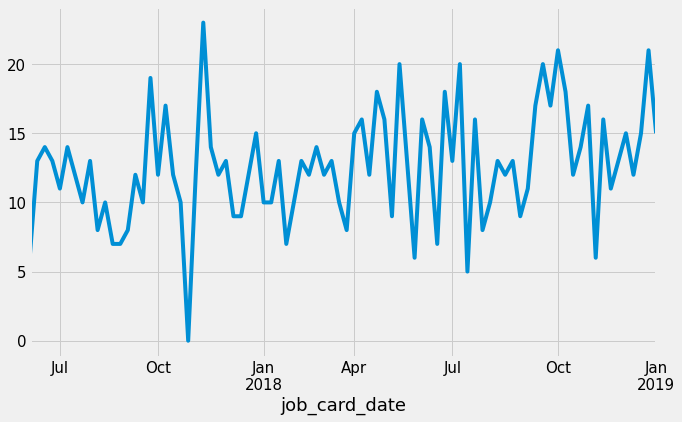

In [70]:
BAJAJPULSAR150EngineOilWeeklyCount.plot()

### Checking Autocorrelation and Partial Autocorrelation

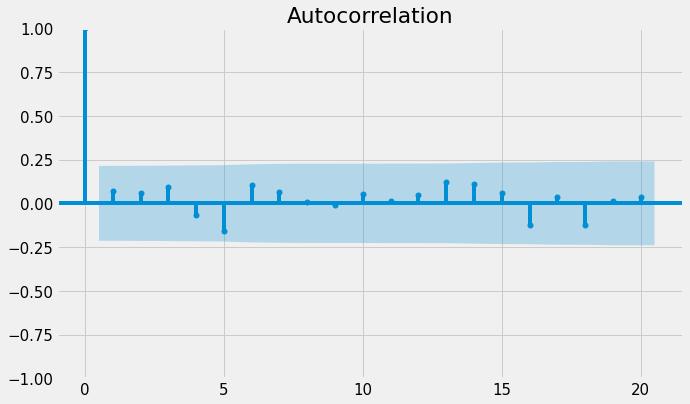

In [71]:
plot_acf(BAJAJPULSAR150EngineOilWeeklyCount)
plt.show() 

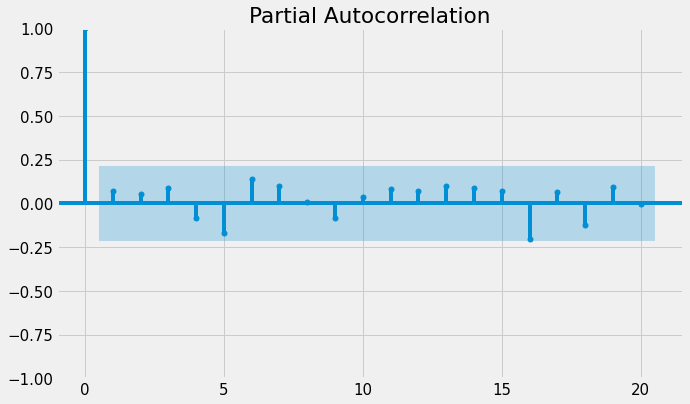

In [72]:
plot_pacf(BAJAJPULSAR150EngineOilWeeklyCount)
plt.show() 

### Checking for Seasonality

#### Finding Period

In [73]:
def find_period(signal):
    acf = np.correlate(signal, signal, 'full')[-len(signal):]
    inflection = np.diff(np.sign(np.diff(acf)))
    peaks = (inflection < 0).nonzero()[0] + 1
    return peaks[acf[peaks].argmax()]

In [74]:
find_period(BAJAJPULSAR150EngineOilWeeklyCount)

6

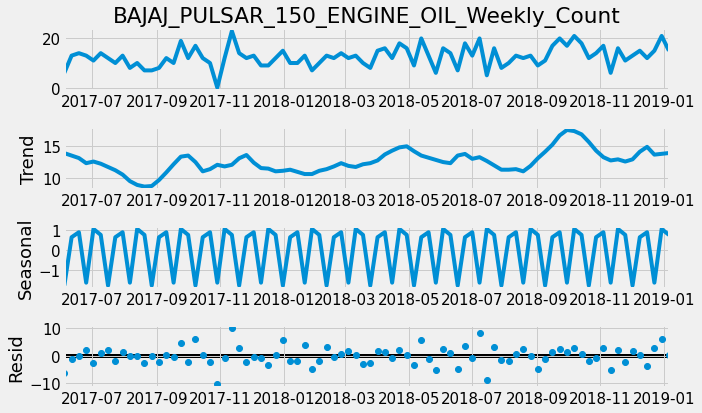

In [75]:
result = seasonal_decompose(BAJAJPULSAR150EngineOilWeeklyCount, model='additive',extrapolate_trend='freq',period=6)
result.plot()
plt.show()

The series is stationary


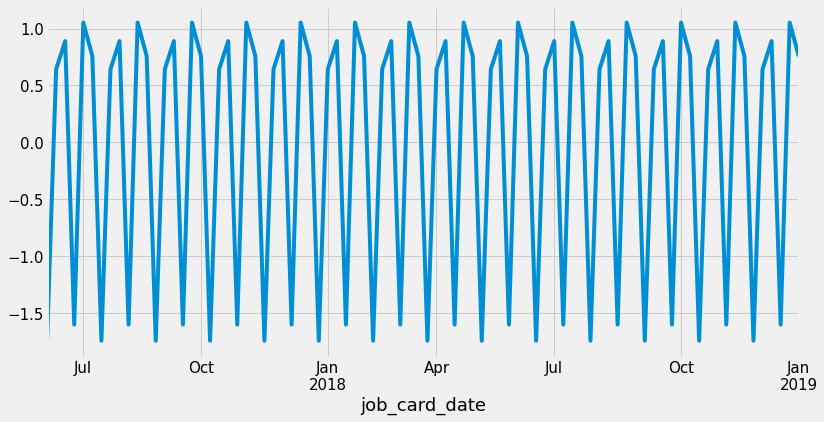

In [76]:
seasonal = result.seasonal
seasonal.plot(figsize=(12,6))
check_stationarity(seasonal)  

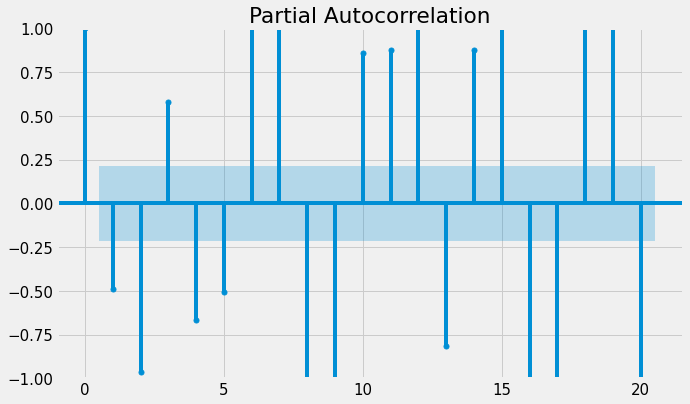

In [77]:
plot_pacf(seasonal)
plt.show()

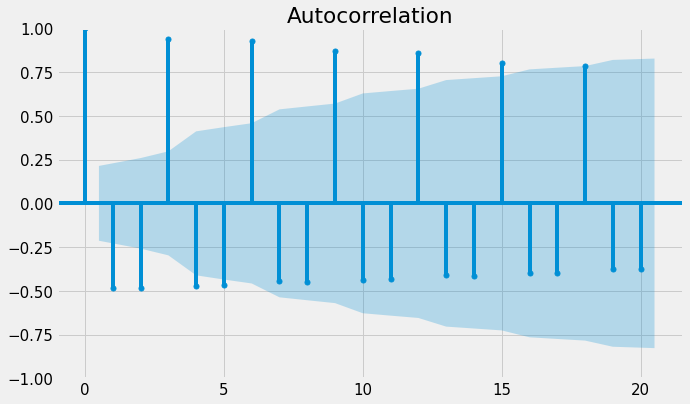

In [78]:
plot_acf(seasonal)
plt.show()

### Creating train and test

In [79]:
train=BAJAJPULSAR150EngineOilWeeklyCount[:69] 
test=BAJAJPULSAR150EngineOilWeeklyCount[69:] 

In [80]:
train.shape

(69,)

### Modelling

#### Accuracy Metrics

In [81]:
def forecast_accuracy(model,forecast, actual):
    AIC = model.aic              
    MAD = np.mean(np.abs(forecast - actual))  
    MSE = np.mean((forecast - actual)**2)
    RMSE = np.mean((forecast - actual)**2)**.5   
    MAPE = np.mean(np.abs(forecast - actual)/np.abs(actual))*100
    return({'AIC': AIC,'MAD': MAD, 'MSE': MSE ,'RMSE': RMSE, 'MAPE': MAPE})

#### Naive Model

In [82]:
base = BAJAJPULSAR150EngineOilWeeklyCount.copy()
base = base.to_frame(name='BAJAJPULSAR150_ENGINEOIL_Weekly_Count')
base

,BAJAJPULSAR150_ENGINEOIL_Weekly_Count
job_card_date,
2017-06-04,6
2017-06-11,13
2017-06-18,14
2017-06-25,13
2017-07-02,11
...,...
2018-12-09,15
2018-12-16,12
2018-12-23,15


In [83]:
base_diff = pd.concat([base,base.shift(1)],axis=1)

In [84]:
base_diff

,BAJAJPULSAR150_ENGINEOIL_Weekly_Count,BAJAJPULSAR150_ENGINEOIL_Weekly_Count
job_card_date,,
2017-06-04,6,NaN
2017-06-11,13,6.0
2017-06-18,14,13.0
2017-06-25,13,14.0
2017-07-02,11,13.0
...,...,...
2018-12-09,15,13.0
2018-12-16,12,15.0
2018-12-23,15,12.0


In [85]:
base_diff.columns = ['Actual_Count','Forecast_Count']

In [86]:
base_diff.dropna(inplace=True)

##### Evaluation

In [87]:
MAD = np.mean(np.abs(base_diff.Forecast_Count - base_diff.Actual_Count))  
MSE = np.mean((base_diff.Forecast_Count - base_diff.Actual_Count)**2)
RMSE = np.mean((base_diff.Forecast_Count - base_diff.Actual_Count)**2)**.5   
print('Mean Absolute Deviation of Naive Model is: ',MAD)
print('Mean Squared Error of Naive Model is: ',MSE)
print('Root Mean Squared Error of Naive Model is: ',RMSE)

Mean Absolute Deviation of Naive Model is:  4.469879518072289
Mean Squared Error of Naive Model is:  30.83132530120482
Root Mean Squared Error of Naive Model is:  5.552596266721075


#### ARIMA model

In [88]:
model_arima = ARIMA(train, order=(1,0,1)) 
model_arima_fit = model_arima.fit()

In [89]:
predictions = model_arima_fit.forecast(steps=15)
predictions 

2018-09-30    11.444014
2018-10-07    11.634985
2018-10-14    11.770420
2018-10-21    11.866469
2018-10-28    11.934586
2018-11-04    11.982894
2018-11-11    12.017153
2018-11-18    12.041449
2018-11-25    12.058680
2018-12-02    12.070900
2018-12-09    12.079566
2018-12-16    12.085712
2018-12-23    12.090071
2018-12-30    12.093162
2019-01-06    12.095354
Freq: W-SUN, Name: predicted_mean, dtype: float64

##### Evaluation

In [90]:
forecast_accuracy(model_arima_fit,predictions,test)

{'AIC': 394.2441300922294,
 'MAD': 3.8705117128380824,
 'MSE': 23.031217329843038,
 'RMSE': 4.7990850513241625,
 'MAPE': 26.694917002499878}

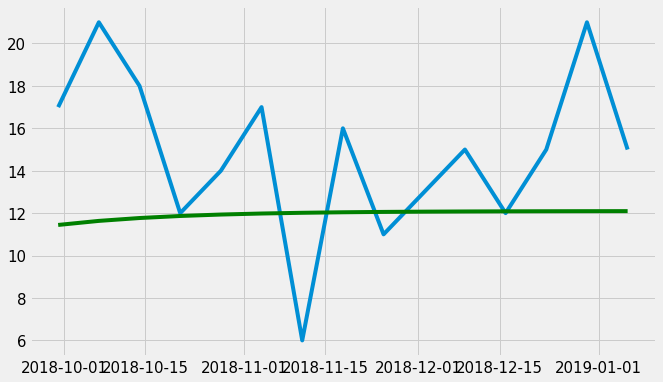

In [91]:
plt.plot(test)
plt.plot(predictions,color='green')

#### HYPERPARAMETER TUNING ARIMA 

AIC and RMSE are inter-related but they represent different objectives in choosing the best model. RMSE/MAPE are measures of error and disregards the "complexity" of the model. Optimizing for RMSE/MAPE can give you accurate results, but could lead to overly complex model. It ultimately comes down to the purpose of your model. If having the most accurate prediction matters then you might simply look at RMSE/MAPE, but if you need a model that is more interpretable/explainable then you might want to consider AIC which better balances complexity and accuracy. Here i am looking more into accuracy and will be modelling based on RMSE.

In [92]:
p=q=range(0,6)
d=range(0,2)
pdq = list(itertools.product(p,d,q))
arima_metric_dict = dict()

In [93]:
for params in pdq:
    try:
        model_arima = ARIMA(train, order=params,)
        model_arima_fit = model_arima.fit()
        pred = model_arima_fit.forecast(steps=15)
        rmse = np.sqrt(mean_squared_error(test,pred))   
        arima_metric_dict.update({(params):[model_arima_fit.aic,rmse]})
    except: 
        continue

In [94]:
arima_aic_sorted_results = {k:v for k,v in sorted(arima_metric_dict.items(),key=lambda x: x[1][0])}
arima_aic_sorted_results_top10 = dict(list(arima_aic_sorted_results.items())[0: 10]) 
arima_aic_sorted_results_df_top10 = pd.DataFrame(arima_aic_sorted_results_top10)
arima_aic_sorted_results_df_top10 = arima_aic_sorted_results_df_top10.T
arima_aic_sorted_results_df_top10.columns = ['AIC','RMSE']
arima_aic_sorted_results_df_top10

AIC      RMSE
0 1 1  390.163082  4.391249
  0 0  390.813479  4.642062
  1 2  392.149753  4.393141
1 1 1  392.151410  4.392637
0 0 1  392.793713  4.652990
1 0 0  392.796215  4.651196
2 1 2  392.910547  4.003786
1 1 3  392.931695  4.011091
0 1 3  393.836327  4.480080
2 1 1  393.917579  4.457070

In [95]:
arima_rmse_sorted_results = {k:v for k,v in sorted(arima_metric_dict.items(),key=lambda x: x[1][1])}
arima_rmse_sorted_results_top10 = dict(list(arima_rmse_sorted_results.items())[0: 10]) 
arima_rmse_sorted_results_df_top10 = pd.DataFrame(arima_rmse_sorted_results_top10)
arima_rmse_sorted_results_df_top10 = arima_rmse_sorted_results_df_top10.T
arima_rmse_sorted_results_df_top10.columns = ['AIC','RMSE']
arima_rmse_sorted_results_df_top10

AIC      RMSE
5 1 0  404.184219  3.730141
2 1 2  392.910547  4.003786
1 1 3  392.931695  4.011091
4 1 0  409.330817  4.048847
3 1 4  398.861512  4.067885
2 1 4  396.948291  4.127772
3 1 0  407.762521  4.141513
4 1 4  400.386373  4.324781
    5  401.680491  4.333982
5 1 3  398.300793  4.356175

In [96]:
model_arima = ARIMA(train, order=(5,1,0)) 
model_arima_fit = model_arima.fit()

In [97]:
prediction = model_arima_fit.forecast(steps=15) 
prediction

2018-09-30    14.302006
2018-10-07    14.929288
2018-10-14    13.919709
2018-10-21    13.814980
2018-10-28    15.158437
2018-11-04    16.251583
2018-11-11    14.797879
2018-11-18    15.043999
2018-11-25    14.841394
2018-12-02    14.672783
2018-12-09    14.948887
2018-12-16    15.310894
2018-12-23    14.930710
2018-12-30    15.009111
2019-01-06    14.983485
Freq: W-SUN, Name: predicted_mean, dtype: float64

##### Evaluation

In [98]:
forecast_accuracy(model_arima_fit,predictions,test)

{'AIC': 404.1842189994265,
 'MAD': 3.8705117128380824,
 'MSE': 23.031217329843038,
 'RMSE': 4.7990850513241625,
 'MAPE': 26.694917002499878}

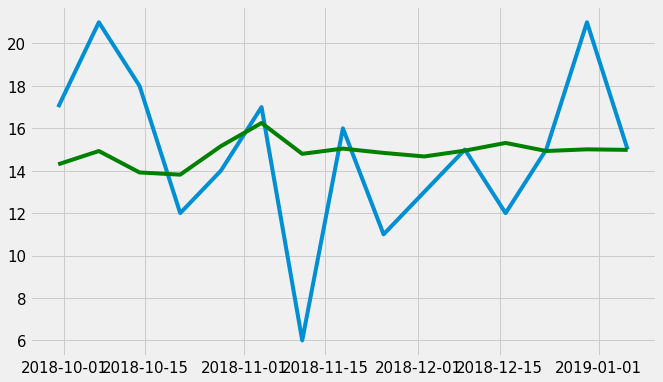

In [99]:
plt.plot(test)
plt.plot(prediction,color='green')

#### SARIMA

In [100]:
model = SARIMAX(train, order=(1,0,1), seasonal_order=(2,0,3,9), enforce_stationarity=False,enforce_invertibility=False)
results = model.fit()

##### Evaluation

In [101]:
y_predicted = results.predict(start=69,end=83,dynamic=False)
y_true = test.copy()
forecast_accuracy(results,y_predicted,y_true)

{'AIC': 235.80639632510565,
 'MAD': 3.0821476145686457,
 'MSE': 14.888922329873152,
 'RMSE': 3.8586166342192056,
 'MAPE': 24.548979527032227}

<AxesSubplot:xlabel='job_card_date'>

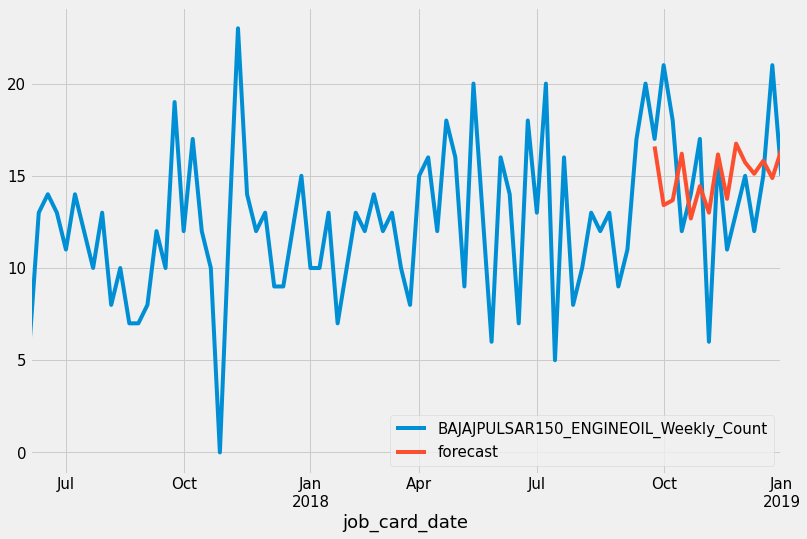

In [102]:
data = BAJAJPULSAR150EngineOilWeeklyCount.copy()
data = data.to_frame(name='BAJAJPULSAR150_ENGINEOIL_Weekly_Count')
data['forecast']= results.predict(start=69,end=83,dynamic=False)
data[['BAJAJPULSAR150_ENGINEOIL_Weekly_Count','forecast']].plot(figsize=(12,8))

##### Future Forecast

In [103]:
# Predicting for the next 3 Months.
pred_date=[data.index[-1]+ DateOffset(weeks=x)for x in range(0,14)]
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
pred_date

,BAJAJPULSAR150_ENGINEOIL_Weekly_Count,forecast
2019-01-13,NaN,NaN
2019-01-20,NaN,NaN
2019-01-27,NaN,NaN
2019-02-03,NaN,NaN
2019-02-10,NaN,NaN
2019-02-17,NaN,NaN
2019-02-24,NaN,NaN
2019-03-03,NaN,NaN
2019-03-10,NaN,NaN
2019-03-17,NaN,NaN


<AxesSubplot:>

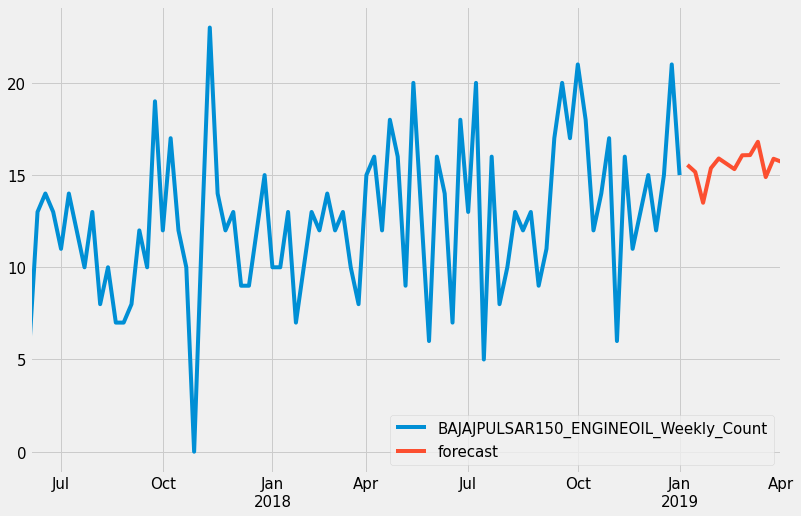

In [104]:
data=pd.concat([data,pred_date])
data['forecast'] = results.predict(start = 84, end = 97, dynamic= False)  
data[['BAJAJPULSAR150_ENGINEOIL_Weekly_Count', 'forecast']].plot(figsize=(12, 8))

#### HYPERPARAMETER TUNING SARIMA

In [105]:
p=q=range(0,6)
d=range(0,2)

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],6) for x in list(itertools.product(p,d,q))]
print('Example of param combo for SARIMA: ')
print('SARIMAX : {} x {}'.format(pdq[1],seasonal_pdq[1]))
print('SARIMAX : {} x {}'.format(pdq[1],seasonal_pdq[2]))
print('SARIMAX : {} x {}'.format(pdq[2],seasonal_pdq[3]))
print('SARIMAX : {} x {}'.format(pdq[2],seasonal_pdq[4]))
print('SARIMAX : {} x {}'.format(pdq[3],seasonal_pdq[5]))

Example of param combo for SARIMA: 
SARIMAX : (0, 0, 1) x (0, 0, 1, 6)
SARIMAX : (0, 0, 1) x (0, 0, 2, 6)
SARIMAX : (0, 0, 2) x (0, 0, 3, 6)
SARIMAX : (0, 0, 2) x (0, 0, 4, 6)
SARIMAX : (0, 0, 3) x (0, 0, 5, 6)


In [106]:
metric_dict = dict()
for pm in pdq:
    for seasonal_pm in seasonal_pdq:
        try:
            model = SARIMAX(train,order=pm,seasonal_order=seasonal_pm,enforce_invertibility=False,
                                              enforce_stationarity=False)
            results = model.fit() 
            y_predicted = results.predict(start=69,end=84,dynamic=False)
            y_true = test
            mse = ((y_predicted - y_true)**2).mean()
            rmse = np.sqrt(mse)
            metric_dict.update({(pm,seasonal_pm):[results.aic,rmse]})   
        except:
            continue

In [107]:
sorted_results_aic = {k:v for k,v in sorted(metric_dict.items(),key=lambda x: x[1][0])}
sorted_results_aic_top10 = dict(list(sorted_results_aic.items())[0: 10]) 
sorted_results_aic_df_top10 = pd.DataFrame(sorted_results_aic_top10)
sorted_results_aic_df_top10 = sorted_results_aic_df_top10.T
sorted_results_aic_df_top10.columns = ['AIC','RMSE']
sorted_results_aic_df_top10

AIC          RMSE
(2, 0, 2) (0, 1, 3, 6)  16.0  9.086043e+32
(2, 1, 2) (0, 1, 3, 6)  16.0  3.044044e+29
(2, 0, 2) (1, 1, 3, 6)  18.0  7.679486e+32
(2, 1, 2) (1, 1, 3, 6)  18.0  4.840305e+30
(3, 0, 2) (0, 1, 3, 6)  18.0  5.090444e+33
(3, 1, 2) (0, 0, 3, 6)  18.0  6.532502e+66
          (0, 1, 3, 6)  18.0  4.431335e+71
(1, 0, 3) (2, 1, 3, 6)  20.0  7.745547e+53
(2, 0, 2) (2, 1, 3, 6)  20.0  1.189389e+33
(2, 1, 2) (2, 1, 3, 6)  20.0  4.437162e+29

In [108]:
sorted_results_rmse = {k:v for k,v in sorted(metric_dict.items(),key=lambda x: x[1][1])}
sorted_results_rmse_top10 = dict(list(sorted_results_rmse.items())[0: 10]) 
sorted_results_rmse_df_top10 = pd.DataFrame(sorted_results_rmse_top10)
sorted_results_rmse_df_top10 = sorted_results_rmse_df_top10.T
sorted_results_rmse_df_top10.columns = ['AIC','RMSE']
sorted_results_rmse_df_top10

,,AIC,RMSE
"(1, 1, 4)","(5, 0, 2, 6)",221.883573,3.032088
"(4, 1, 5)","(5, 0, 1, 6)",213.209532,3.066979
"(3, 0, 5)","(3, 0, 5, 6)",206.589729,3.081513
"(2, 1, 4)","(5, 0, 2, 6)",218.046838,3.100591
"(5, 0, 5)","(2, 0, 2, 6)",319.896811,3.147176
"(4, 1, 5)","(5, 0, 0, 6)",212.258153,3.147405
"(3, 1, 5)","(5, 0, 1, 6)",217.453254,3.147938
"(3, 1, 4)","(5, 0, 2, 6)",216.478917,3.164770
"(2, 1, 4)","(5, 0, 1, 6)",219.188497,3.168365
"(3, 1, 5)","(5, 0, 0, 6)",215.682373,3.178511


In [109]:
model = SARIMAX(train, order=(1,1,4), seasonal_order=(5,0,2,6),enforce_stationarity=False,enforce_invertibility=False)
results = model.fit()

##### Evaluation

In [110]:
y_predicted = results.predict(start=69,end=83,dynamic=False)
y_true = test.copy()
forecast_accuracy(results,y_predicted,y_true)

{'AIC': 221.8835733573948,
 'MAD': 2.5589269154099044,
 'MSE': 9.193558738355168,
 'RMSE': 3.0320881811641245,
 'MAPE': 20.290865701454468}

<AxesSubplot:xlabel='job_card_date'>

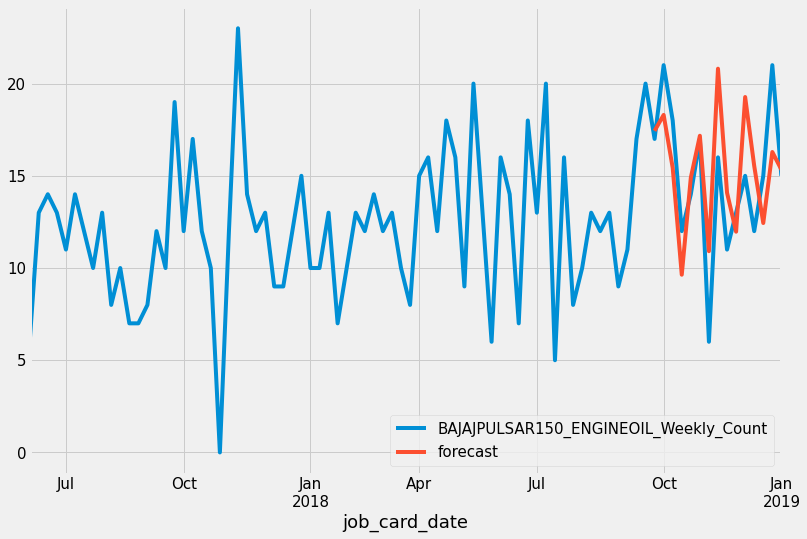

In [111]:
data = BAJAJPULSAR150EngineOilWeeklyCount.copy()
data = data.to_frame(name='BAJAJPULSAR150_ENGINEOIL_Weekly_Count')
data['forecast']= results.predict(start=69,end=83,dynamic=False)
data[['BAJAJPULSAR150_ENGINEOIL_Weekly_Count','forecast']].plot(figsize=(12,8))

##### Future Forecast

In [112]:
pred_date=[data.index[-1]+ DateOffset(weeks=x)for x in range(0,14)]
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
pred_date

,BAJAJPULSAR150_ENGINEOIL_Weekly_Count,forecast
2019-01-13,NaN,NaN
2019-01-20,NaN,NaN
2019-01-27,NaN,NaN
2019-02-03,NaN,NaN
2019-02-10,NaN,NaN
2019-02-17,NaN,NaN
2019-02-24,NaN,NaN
2019-03-03,NaN,NaN
2019-03-10,NaN,NaN
2019-03-17,NaN,NaN


<AxesSubplot:>

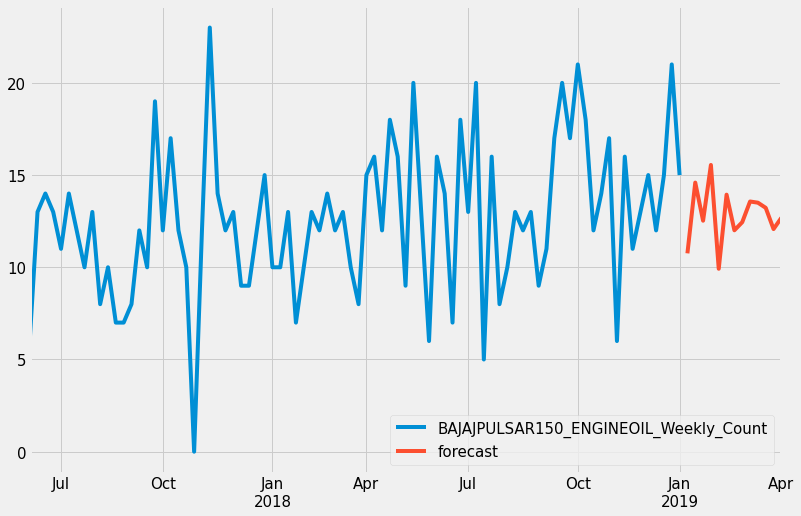

In [113]:
data=pd.concat([data,pred_date])
data['forecast'] = results.predict(start = 84, end = 97, dynamic= False)  
data[['BAJAJPULSAR150_ENGINEOIL_Weekly_Count', 'forecast']].plot(figsize=(12, 8))

#### Fbprophet

In [114]:
fb = Vehicle_Spares[0].copy()
fb.reset_index(inplace=True)
fb.columns = ['ds','y']

In [115]:
from prophet import Prophet
fb_train = fb[:69]
fb_test = fb[69:]

In [116]:
# Initialize the Model
fb_model=Prophet(interval_width=0.95,yearly_seasonality=True,seasonality_mode='additive')

In [117]:
fb_model.fit(fb_train) 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [118]:
### Create future dates for test data
fb_future_dates=fb_model.make_future_dataframe(periods=fb_test.shape[0], freq='W')   
fb_prediction=fb_model.predict(fb_future_dates)
fb_prediction[['ds','yhat','yhat_upper','yhat_lower']].tail()

,ds,yhat,yhat_upper,yhat_lower
79,2018-12-09,10.951218,16.671228,4.960790
80,2018-12-16,11.818716,17.363984,5.849083
81,2018-12-23,13.975073,19.872604,8.026575
82,2018-12-30,15.098676,21.101303,9.353596
83,2019-01-06,14.452452,20.315351,8.061720


<AxesSubplot:xlabel='ds'>

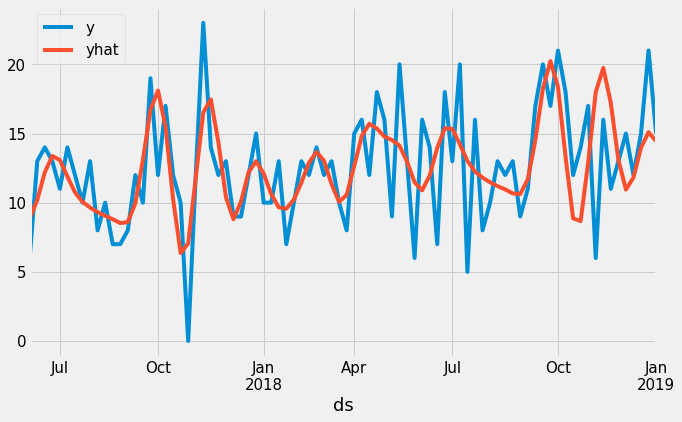

In [119]:
pd.concat([fb.set_index('ds')['y'],fb_prediction.set_index('ds')['yhat']],axis=1).plot()

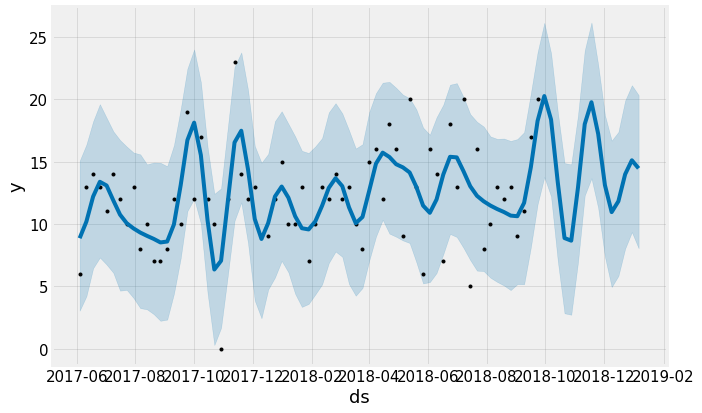

In [120]:
### plot the predicted projection
fb_model.plot(fb_prediction);

##### Evaluation

In [121]:
from prophet.diagnostics import cross_validation
fb_cv = cross_validation(fb_model, initial='60 W', period='1 W', horizon = '3 W',disable_tqdm=True)
fb_cv.head()    

INFO:prophet:Making 6 forecasts with cutoffs between 2018-07-29 00:00:00 and 2018-09-02 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-08-05,10.133803,3.919785,16.615627,10,2018-07-29
1,2018-08-12,8.926313,2.814156,15.361972,13,2018-07-29
2,2018-08-19,8.468883,2.405070,14.441738,12,2018-07-29
3,2018-08-12,8.879197,2.633789,14.849046,13,2018-08-05
4,2018-08-19,8.434246,2.106368,14.909453,12,2018-08-05


In [122]:
from prophet.diagnostics import performance_metrics
fb_perf = performance_metrics(fb_cv)
fb_perf

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,5.612997,2.369176,1.926753,0.162863,0.202173,0.177074,1.0
1,14 days,10.024579,3.166162,2.770392,0.211169,0.256215,0.240826,1.0
2,21 days,9.871729,3.141931,2.704608,0.188387,0.204252,0.215034,1.0


In [123]:
fb_predicted = fb_prediction['yhat'][69:].values
fb_true = fb_test['y'].values

In [124]:
MAD = np.mean(np.abs(fb_predicted - fb_true))  
MSE = np.mean((fb_predicted - fb_true)**2)
RMSE = np.mean((fb_predicted - fb_true)**2)**.5   
print('Mean Absolute Deviation of Naive Model is: ',MAD)
print('Mean Squared Error of Naive Model is: ',MSE)
print('Root Mean Squared Error of Naive Model is: ',RMSE)

Mean Absolute Deviation of Naive Model is:  3.790039298398081
Mean Squared Error of Naive Model is:  22.87193887679584
Root Mean Squared Error of Naive Model is:  4.782461591774244


> - As you can see from above, SARIMA gives us the best results.
> - Other models were tried but these models shown above gave better results.

## Bajaj Pulsar 150 - Chain Lubricant

In [125]:
BAJAJPULSAR150CHAINLUBRICANTWeeklyCount = Vehicle_Spares[1].copy()
BAJAJPULSAR150CHAINLUBRICANTWeeklyCount

,BAJAJ_PULSAR_150_CHAIN_LUBRICANT_Weekly_Count
job_card_date,
2017-06-04,6
2017-06-11,12
2017-06-18,15
2017-06-25,13
2017-07-02,11
...,...
2018-12-09,14
2018-12-16,12
2018-12-23,13


In [126]:
# To convert it to Series
BAJAJPULSAR150CHAINLUBRICANTWeeklyCount = BAJAJPULSAR150CHAINLUBRICANTWeeklyCount.squeeze() 
BAJAJPULSAR150CHAINLUBRICANTWeeklyCount

job_card_date
2017-06-04     6
2017-06-11    12
2017-06-18    15
2017-06-25    13
2017-07-02    11
              ..
2018-12-09    14
2018-12-16    12
2018-12-23    13
2018-12-30    19
2019-01-06    14
Freq: W-SUN, Name: BAJAJ_PULSAR_150_CHAIN_LUBRICANT_Weekly_Count, Length: 84, dtype: int64

### Checking Stationarity

In [128]:
check_stationarity(BAJAJPULSAR150CHAINLUBRICANTWeeklyCount)

The series is stationary


<AxesSubplot:xlabel='job_card_date'>

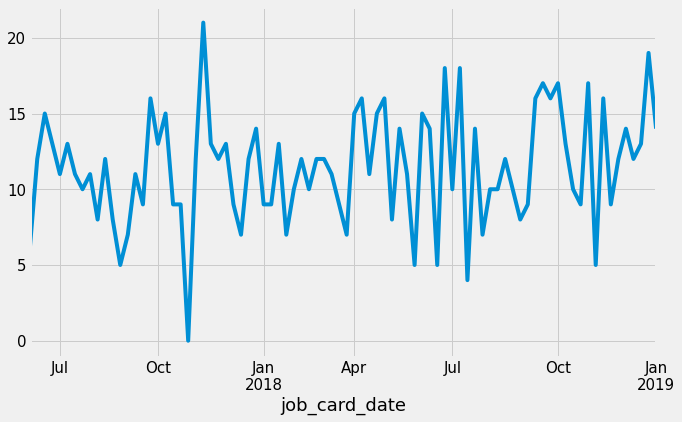

In [129]:
BAJAJPULSAR150CHAINLUBRICANTWeeklyCount.plot()

### Checking Autocorrelation and Partial Autocorrelation

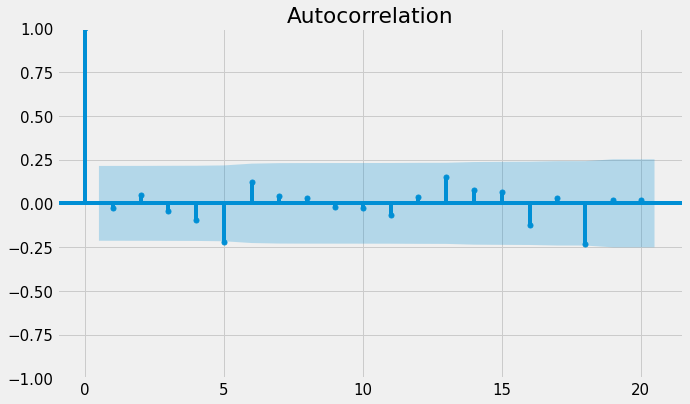

In [130]:
plot_acf(BAJAJPULSAR150CHAINLUBRICANTWeeklyCount)
plt.show() 

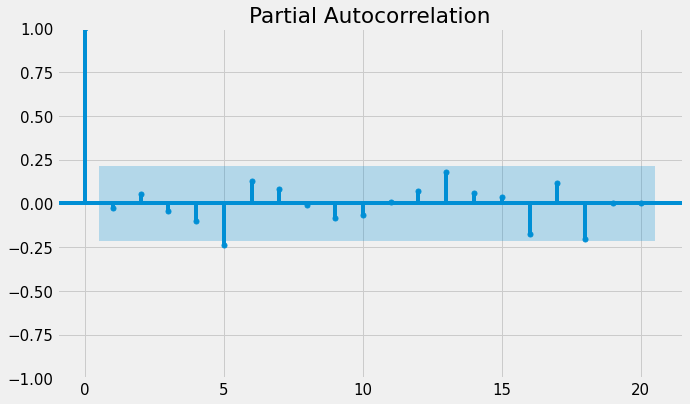

In [131]:
plot_pacf(BAJAJPULSAR150CHAINLUBRICANTWeeklyCount)
plt.show() 

### Checking for Seasonality

#### Finding Period

In [132]:
find_period(BAJAJPULSAR150CHAINLUBRICANTWeeklyCount)

6

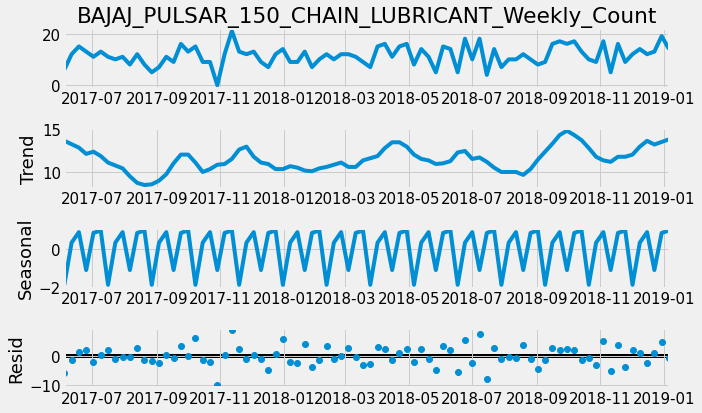

In [133]:
result = seasonal_decompose(BAJAJPULSAR150CHAINLUBRICANTWeeklyCount, model='additive',extrapolate_trend='freq',period=6)
result.plot()
plt.show()

The series is stationary


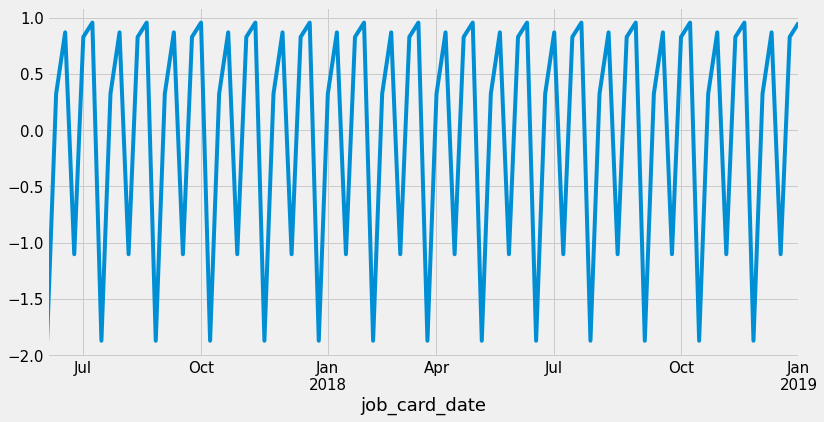

In [134]:
seasonal = result.seasonal
seasonal.plot(figsize=(12,6))
check_stationarity(seasonal)  

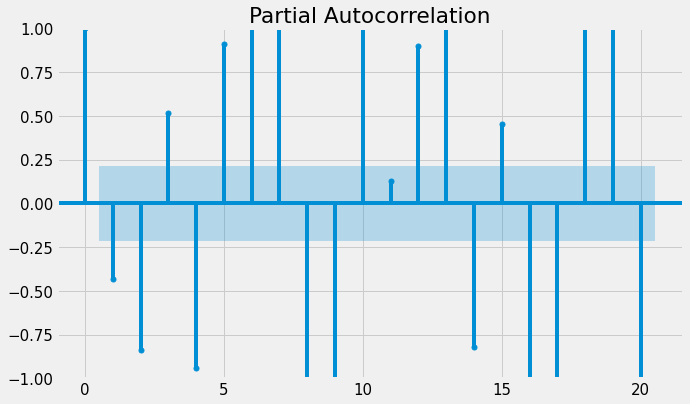

In [135]:
plot_pacf(seasonal)
plt.show()

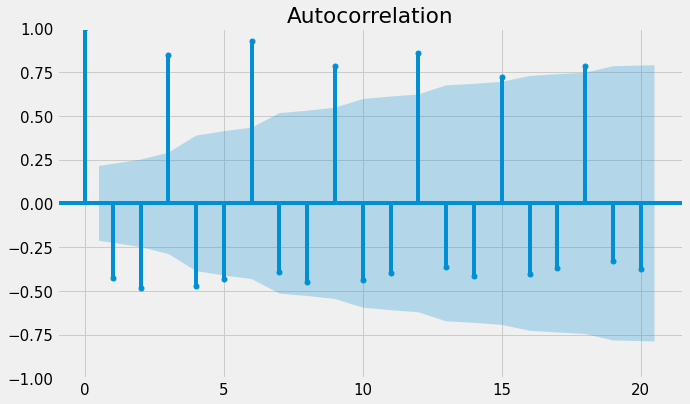

In [136]:
plot_acf(seasonal)
plt.show()

### Creating train and test

In [137]:
train=BAJAJPULSAR150CHAINLUBRICANTWeeklyCount[:69] 
test=BAJAJPULSAR150CHAINLUBRICANTWeeklyCount[69:] 

In [138]:
train.shape

(69,)

### Modelling

#### Naive Model

In [139]:
base = BAJAJPULSAR150CHAINLUBRICANTWeeklyCount.copy()
base = base.to_frame(name='BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count')
base

,BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count
job_card_date,
2017-06-04,6
2017-06-11,12
2017-06-18,15
2017-06-25,13
2017-07-02,11
...,...
2018-12-09,14
2018-12-16,12
2018-12-23,13


In [140]:
base_diff = pd.concat([base,base.shift(1)],axis=1)

In [141]:
base_diff

,BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count,BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count
job_card_date,,
2017-06-04,6,NaN
2017-06-11,12,6.0
2017-06-18,15,12.0
2017-06-25,13,15.0
2017-07-02,11,13.0
...,...,...
2018-12-09,14,12.0
2018-12-16,12,14.0
2018-12-23,13,12.0


In [142]:
base_diff.columns = ['Actual_Count','Forecast_Count']

In [143]:
base_diff.dropna(inplace=True)

##### Evaluation

In [144]:
MAD = np.mean(np.abs(base_diff.Forecast_Count - base_diff.Actual_Count))  
MSE = np.mean((base_diff.Forecast_Count - base_diff.Actual_Count)**2)
RMSE = np.mean((base_diff.Forecast_Count - base_diff.Actual_Count)**2)**.5   
print('Mean Absolute Deviation of Naive Model is: ',MAD)
print('Mean Squared Error of Naive Model is: ',MSE)
print('Root Mean Squared Error of Naive Model is: ',RMSE)

Mean Absolute Deviation of Naive Model is:  4.192771084337349
Mean Squared Error of Naive Model is:  28.867469879518072
Root Mean Squared Error of Naive Model is:  5.3728456035436265


#### ARIMA model

In [145]:
model_arima = ARIMA(train, order=(5,0,5))  
model_arima_fit = model_arima.fit()

In [146]:
predictions = model_arima_fit.forecast(steps=15)
predictions 

2018-09-30    11.280990
2018-10-07    11.523664
2018-10-14    10.002714
2018-10-21     8.392535
2018-10-28     9.627454
2018-11-04    12.059375
2018-11-11    11.981477
2018-11-18    11.553752
2018-11-25    11.059286
2018-12-02    10.814146
2018-12-09    10.736487
2018-12-16    10.993099
2018-12-23    11.147319
2018-12-30    11.188286
2019-01-06    11.122182
Freq: W-SUN, Name: predicted_mean, dtype: float64

##### Evaluation

In [147]:
forecast_accuracy(model_arima_fit,predictions,test)

{'AIC': 391.6272310268139,
 'MAD': 3.4569112132213577,
 'MSE': 16.479267772605937,
 'RMSE': 4.059466439398895,
 'MAPE': 29.645152942752855}

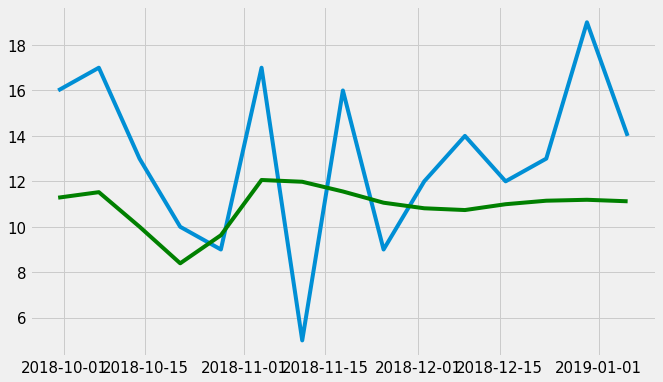

In [148]:
plt.plot(test)
plt.plot(predictions,color='green')

#### HYPERPARAMETER TUNING ARIMA 

In [149]:
p=q=range(0,6)
d=range(0,2)
pdq = list(itertools.product(p,d,q))
arima_metric_dict = dict()

In [150]:
for params in pdq:
    try:
        model_arima = ARIMA(train, order=params,)
        model_arima_fit = model_arima.fit()
        pred = model_arima_fit.forecast(steps=15)
        rmse = np.sqrt(mean_squared_error(test,pred))   
        arima_metric_dict.update({(params):[model_arima_fit.aic,rmse]})
    except: 
        continue

In [151]:
arima_aic_sorted_results = {k:v for k,v in sorted(arima_metric_dict.items(),key=lambda x: x[1][0])}
arima_aic_sorted_results_top10 = dict(list(arima_aic_sorted_results.items())[0: 10]) 
arima_aic_sorted_results_df_top10 = pd.DataFrame(arima_aic_sorted_results_top10)
arima_aic_sorted_results_df_top10 = arima_aic_sorted_results_df_top10.T
arima_aic_sorted_results_df_top10.columns = ['AIC','RMSE']
arima_aic_sorted_results_df_top10

AIC      RMSE
0 1 1  379.824127  4.105795
  0 0  380.047153  4.105807
1 0 1  380.172489  4.346694
0 1 2  381.729636  4.126468
1 1 1  381.739856  4.122658
0 0 1  381.847654  4.136773
1 0 0  381.875943  4.129199
2 0 1  382.411207  4.278406
5 0 0  382.431365  4.161137
1 0 2  382.437695  4.287736

In [152]:
arima_rmse_sorted_results = {k:v for k,v in sorted(arima_metric_dict.items(),key=lambda x: x[1][1])}
arima_rmse_sorted_results_top10 = dict(list(arima_rmse_sorted_results.items())[0: 10]) 
arima_rmse_sorted_results_df_top10 = pd.DataFrame(arima_rmse_sorted_results_top10)
arima_rmse_sorted_results_df_top10 = arima_rmse_sorted_results_df_top10.T
arima_rmse_sorted_results_df_top10.columns = ['AIC','RMSE']
arima_rmse_sorted_results_df_top10

,,,AIC,RMSE
5,1,0,393.838616,3.533615
4,1,3,389.609215,3.742833
2,1,4,386.823763,3.794692
4,1,0,401.503646,3.863941
3,1,0,399.814419,3.932579
0,0,5,382.818027,3.994248
1,0,5,384.476327,3.996654
2,1,3,385.653126,3.998876
5,1,5,390.414401,4.000230
4,1,5,390.186028,4.035988


In [153]:
model_arima = ARIMA(train, order=(5,1,0)) 
model_arima_fit = model_arima.fit()

In [154]:
prediction = model_arima_fit.forecast(steps=15) 
prediction

2018-09-30    13.191764
2018-10-07    12.703649
2018-10-14    11.916501
2018-10-21    11.563605
2018-10-28    13.521862
2018-11-04    14.189586
2018-11-11    13.173115
2018-11-18    13.088607
2018-11-25    12.859307
2018-12-02    12.574161
2018-12-09    13.083272
2018-12-16    13.374770
2018-12-23    13.102014
2018-12-30    13.097466
2019-01-06    13.047845
Freq: W-SUN, Name: predicted_mean, dtype: float64

##### Evaluation

In [155]:
forecast_accuracy(model_arima_fit,predictions,test)

{'AIC': 393.8386156460013,
 'MAD': 3.4569112132213577,
 'MSE': 16.479267772605937,
 'RMSE': 4.059466439398895,
 'MAPE': 29.645152942752855}

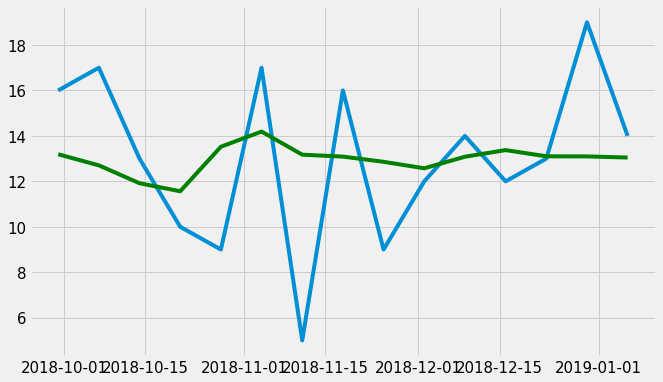

In [156]:
plt.plot(test)
plt.plot(prediction,color='green')

#### SARIMA

In [157]:
model = SARIMAX(train, order=(5,0,5), seasonal_order=(3,0,2,6), enforce_stationarity=False,enforce_invertibility=False)
results = model.fit()

##### Evaluation

In [158]:
y_predicted = results.predict(start=69,end=83,dynamic=False)
y_true = test.copy()
forecast_accuracy(results,y_predicted,y_true)

{'AIC': 268.13272089159534,
 'MAD': 2.690331630358199,
 'MSE': 9.57528037962447,
 'RMSE': 3.0943949941183124,
 'MAPE': 24.06761508144101}

<AxesSubplot:xlabel='job_card_date'>

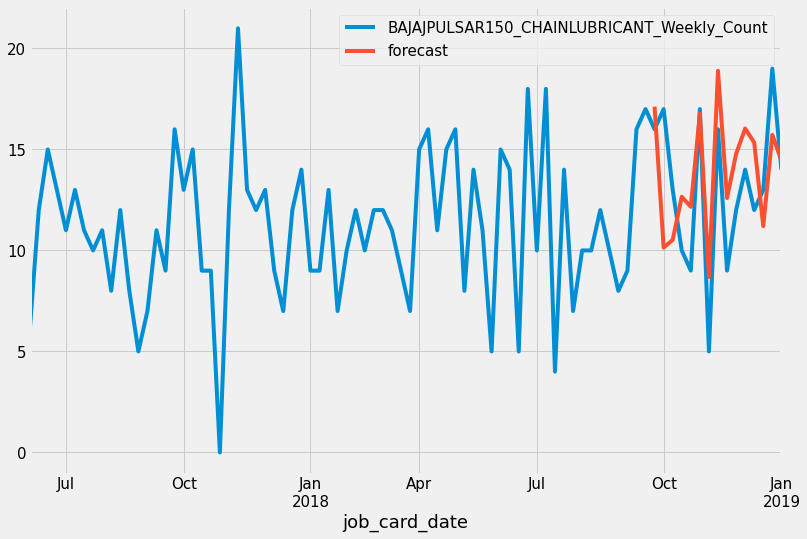

In [159]:
data = BAJAJPULSAR150CHAINLUBRICANTWeeklyCount.copy()
data = data.to_frame(name='BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count')
data['forecast']= results.predict(start=69,end=83,dynamic=False)
data[['BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count','forecast']].plot(figsize=(12,8))

##### Future Forecast

In [160]:
pred_date=[data.index[-1]+ DateOffset(weeks=x)for x in range(0,14)]
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
pred_date

,BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count,forecast
2019-01-13,NaN,NaN
2019-01-20,NaN,NaN
2019-01-27,NaN,NaN
2019-02-03,NaN,NaN
2019-02-10,NaN,NaN
2019-02-17,NaN,NaN
2019-02-24,NaN,NaN
2019-03-03,NaN,NaN
2019-03-10,NaN,NaN
2019-03-17,NaN,NaN


<AxesSubplot:>

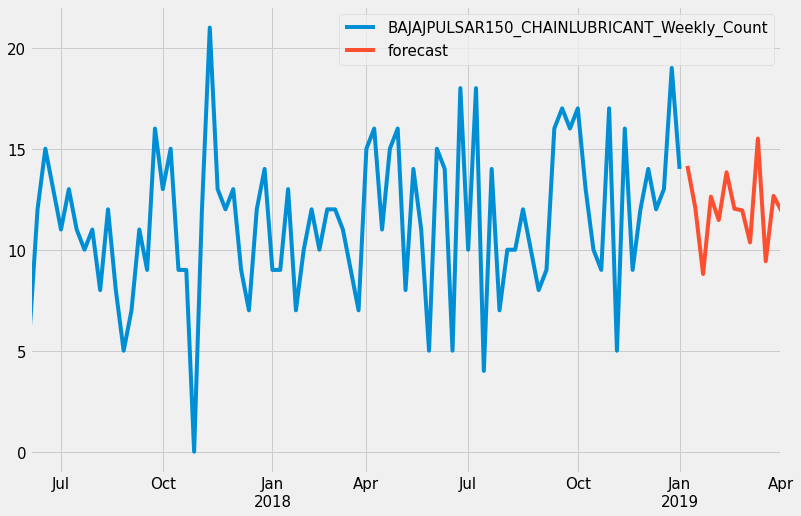

In [161]:
data=pd.concat([data,pred_date])
data['forecast'] = results.predict(start = 84, end = 97, dynamic= False)  
data[['BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count', 'forecast']].plot(figsize=(12, 8))

#### HYPERPARAMETER TUNING SARIMA

In [162]:
p=q=range(0,6)
d=range(0,2)

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],6) for x in list(itertools.product(p,d,q))]
print('Example of param combo for SARIMA: ')
print('SARIMAX : {} x {}'.format(pdq[1],seasonal_pdq[1]))
print('SARIMAX : {} x {}'.format(pdq[1],seasonal_pdq[2]))
print('SARIMAX : {} x {}'.format(pdq[2],seasonal_pdq[3]))
print('SARIMAX : {} x {}'.format(pdq[2],seasonal_pdq[4]))
print('SARIMAX : {} x {}'.format(pdq[3],seasonal_pdq[5]))

Example of param combo for SARIMA: 
SARIMAX : (0, 0, 1) x (0, 0, 1, 6)
SARIMAX : (0, 0, 1) x (0, 0, 2, 6)
SARIMAX : (0, 0, 2) x (0, 0, 3, 6)
SARIMAX : (0, 0, 2) x (0, 0, 4, 6)
SARIMAX : (0, 0, 3) x (0, 0, 5, 6)


In [163]:
metric_dict = dict()
for pm in pdq:
    for seasonal_pm in seasonal_pdq:
        try:
            model = SARIMAX(train,order=pm,seasonal_order=seasonal_pm,enforce_invertibility=False,
                                              enforce_stationarity=False)
            results = model.fit() 
            y_predicted = results.predict(start=69,end=84,dynamic=False)
            y_true = test
            mse = ((y_predicted - y_true)**2).mean()
            rmse = np.sqrt(mse)
            metric_dict.update({(pm,seasonal_pm):[results.aic,rmse]})   
        except:
            continue

In [164]:
sorted_results_aic = {k:v for k,v in sorted(metric_dict.items(),key=lambda x: x[1][0])}
sorted_results_aic_top10 = dict(list(sorted_results_aic.items())[0: 10]) 
sorted_results_aic_df_top10 = pd.DataFrame(sorted_results_aic_top10)
sorted_results_aic_df_top10 = sorted_results_aic_df_top10.T
sorted_results_aic_df_top10.columns = ['AIC','RMSE']
sorted_results_aic_df_top10

AIC           RMSE
(1, 0, 1) (1, 1, 3, 6)  14.0   1.790501e+34
(1, 1, 2) (0, 0, 3, 6)  14.0   2.057123e+40
          (0, 1, 3, 6)  14.0   1.667197e+39
(2, 0, 1) (0, 1, 3, 6)  14.0  8.462800e+125
(1, 0, 1) (2, 1, 3, 6)  16.0   2.072548e+77
(1, 1, 2) (1, 0, 3, 6)  16.0   1.953107e+40
          (1, 1, 3, 6)  16.0   6.137144e+39
(2, 0, 1) (1, 1, 3, 6)  16.0  8.600283e+125
(2, 1, 2) (0, 0, 3, 6)  16.0   1.459005e+52
          (0, 1, 3, 6)  16.0   4.474468e+53

In [165]:
sorted_results_rmse = {k:v for k,v in sorted(metric_dict.items(),key=lambda x: x[1][1])}
sorted_results_rmse_top10 = dict(list(sorted_results_rmse.items())[0: 10]) 
sorted_results_rmse_df_top10 = pd.DataFrame(sorted_results_rmse_top10)
sorted_results_rmse_df_top10 = sorted_results_rmse_df_top10.T
sorted_results_rmse_df_top10.columns = ['AIC','RMSE']
sorted_results_rmse_df_top10

,,AIC,RMSE
"(1, 0, 5)","(4, 0, 2, 6)",251.917987,2.897104
"(3, 1, 3)","(3, 0, 2, 6)",266.555457,2.910567
"(2, 0, 4)","(4, 0, 2, 6)",247.386827,2.911052
"(4, 0, 5)","(2, 0, 2, 6)",310.611367,2.928131
"(3, 0, 5)","(4, 0, 2, 6)",246.616029,2.936824
"(2, 0, 2)","(3, 0, 2, 6)",286.420217,2.938201
"(5, 0, 3)","(3, 0, 2, 6)",272.567710,2.938650
"(4, 0, 4)","(4, 0, 2, 6)",240.827253,2.951609
"(2, 0, 1)","(3, 0, 2, 6)",283.377912,2.952237
"(2, 0, 5)","(4, 0, 2, 6)",249.163372,2.952315


In [166]:
model = SARIMAX(train, order=(1,0,5), seasonal_order=(4,0,2,6),enforce_stationarity=False,enforce_invertibility=False)
results = model.fit()

##### Evaluation

In [167]:
y_predicted = results.predict(start=69,end=83,dynamic=False)
y_true = test.copy()
forecast_accuracy(results,y_predicted,y_true)

{'AIC': 251.9179873226988,
 'MAD': 2.231333927636965,
 'MSE': 8.393210387517094,
 'RMSE': 2.897103793017622,
 'MAPE': 19.644923219014203}

<AxesSubplot:xlabel='job_card_date'>

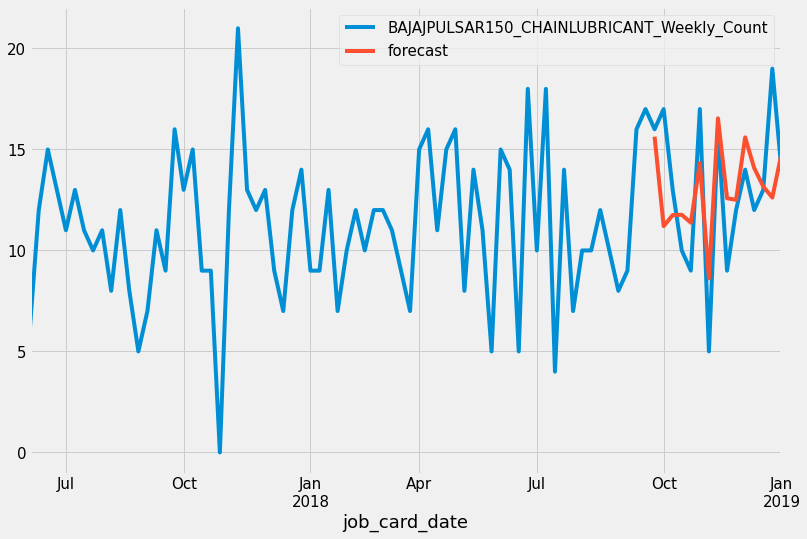

In [168]:
data = BAJAJPULSAR150CHAINLUBRICANTWeeklyCount.copy()
data = data.to_frame(name='BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count')
data['forecast'] = results.predict(start=69,end=83,dynamic=False)
data[['BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count','forecast']].plot(figsize=(12,8))

##### Future Forecast

In [169]:
pred_date=[data.index[-1]+ DateOffset(weeks=x)for x in range(0,14)]
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
pred_date

,BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count,forecast
2019-01-13,NaN,NaN
2019-01-20,NaN,NaN
2019-01-27,NaN,NaN
2019-02-03,NaN,NaN
2019-02-10,NaN,NaN
2019-02-17,NaN,NaN
2019-02-24,NaN,NaN
2019-03-03,NaN,NaN
2019-03-10,NaN,NaN
2019-03-17,NaN,NaN


<AxesSubplot:>

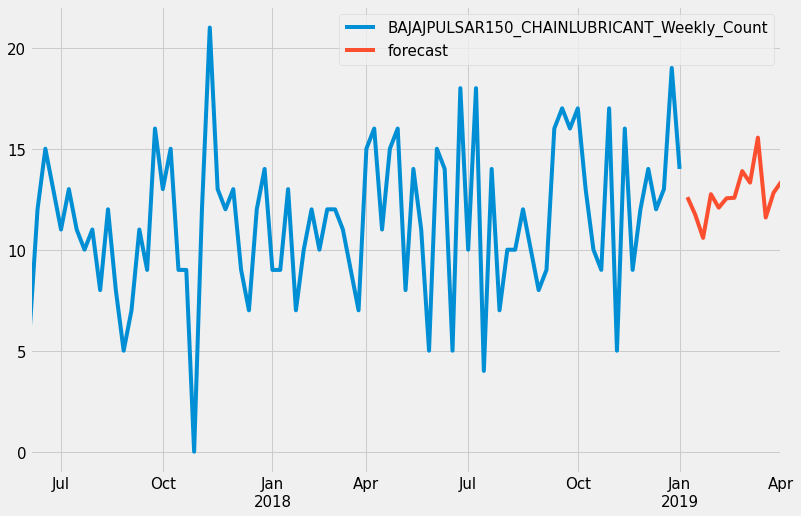

In [170]:
data=pd.concat([data,pred_date])
data['forecast'] = results.predict(start = 84, end = 97, dynamic= False)  
data[['BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count', 'forecast']].plot(figsize=(12, 8))

#### Fbprophet

In [171]:
fb1 = Vehicle_Spares[1].copy()
fb1.reset_index(inplace=True)
fb1.columns = ['ds','y']

In [172]:
from prophet import Prophet
fb1_train = fb1[:69]
fb1_test = fb1[69:]

In [173]:
fb1_model=Prophet(interval_width=0.95,yearly_seasonality=True,seasonality_mode='additive')

In [174]:
fb1_model.fit(fb1_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [175]:
fb1_future_dates=fb1_model.make_future_dataframe(fb1_test.shape[0], freq='W')
fb1_prediction=fb1_model.predict(fb1_future_dates)
fb1_prediction[['ds','yhat','yhat_upper','yhat_lower']].tail()

,ds,yhat,yhat_upper,yhat_lower
79,2018-12-09,9.856252,15.109276,4.296619
80,2018-12-16,10.357381,16.308477,4.658437
81,2018-12-23,11.987993,17.579936,6.515060
82,2018-12-30,12.891412,18.469275,7.339878
83,2019-01-06,12.486893,17.961593,7.103109


<AxesSubplot:xlabel='ds'>

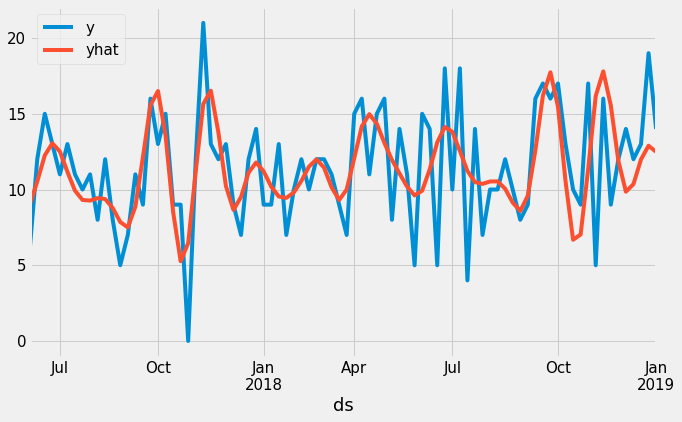

In [176]:
pd.concat([fb1.set_index('ds')['y'],fb1_prediction.set_index('ds')['yhat']],axis=1).plot()

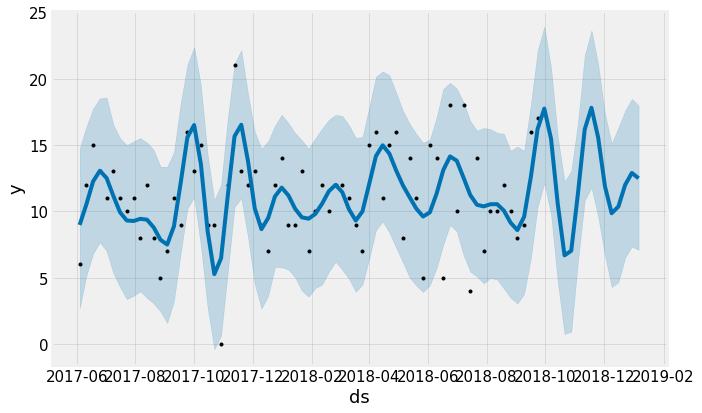

In [177]:
fb1_model.plot(fb1_prediction);

##### Evaluation

In [178]:
fb1_cv = cross_validation(fb1_model, initial='60 W', period='1 W', horizon = '3 W',disable_tqdm=True)
fb1_cv.head()

INFO:prophet:Making 6 forecasts with cutoffs between 2018-07-29 00:00:00 and 2018-09-02 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-08-05,9.555242,4.010755,15.464378,10,2018-07-29
1,2018-08-12,9.023971,3.038721,14.925494,10,2018-07-29
2,2018-08-19,8.352948,2.631643,14.071291,12,2018-07-29
3,2018-08-12,9.128361,3.321511,15.315838,10,2018-08-05
4,2018-08-19,8.405011,3.307068,14.059277,12,2018-08-05


In [179]:
fb1_perf = performance_metrics(fb1_cv)
fb1_perf

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,2.350235,1.533048,1.125348,0.105299,0.082049,0.115418,1.0
1,14 days,7.946163,2.818894,2.158853,0.174566,0.161214,0.200467,1.0
2,21 days,9.241063,3.039912,2.613766,0.205135,0.198338,0.234532,1.0


In [180]:
fb1_predicted = fb1_prediction['yhat'][69:].values
fb1_true = fb1_test['y'].values

In [181]:
MAD = np.mean(np.abs(fb1_predicted - fb1_true))  
MSE = np.mean((fb1_predicted - fb1_true)**2)
RMSE = np.mean((fb1_predicted - fb1_true)**2)**.5   
print('Mean Absolute Deviation of Naive Model is: ',MAD)
print('Mean Squared Error of Naive Model is: ',MSE)
print('Root Mean Squared Error of Naive Model is: ',RMSE)

Mean Absolute Deviation of Naive Model is:  3.3808638469149703
Mean Squared Error of Naive Model is:  19.309029272902503
Root Mean Squared Error of Naive Model is:  4.394204054536214


# Conclusion

SARIMA was the best model for both the data sources. More complex modelling would lead to overfitting so i have kept p and q values below order 5. We also could have got better results if there was a lot of data at our disposal. Also, data is almost similar to random data which we get to know from observing the acf and pacf plots. The same procedures can be implemented for rest of the vehicle models and their spare parts but as shown data is quiet low for time series forecasting of even the top spare parts. Different ML models such as linear regression, xgboost and DL model - LSTM were tried but they gave worst results. With this we have come to an end of this project. Decent results were achieved and with a little more fine tuning can be implemented in real world scenario. Thank you.

---